# Summer Olympics Analysis

## I. Overview

The Summer Olympics is an international multi-sport event that occurs every four years. This report aims to provide a comprehensive comparative analysis of various aspects related to the Olympics held starting from 1896 to 2024, including medal correlations, country rankings, and the performance of top-performing countries. The data used in this report is derived from multiple sources and is presented in the form of dataframes for ease of analysis.

### A. Methodologies

1. **Data Collection**: Gather data from official Olympic sources, sports databases, and socio-economic datasets.
2. **Data Cleaning**: Process and clean the data to ensure accuracy and consistency.
3. **Data Analysis**: Use statistical methods and data visualization techniques to analyze the data.
4. **Correlation Analysis**: Identify and analyze correlations between medal counts and socio-economic factors.
5. **Ranking**: Develop a ranking system to evaluate country performance.
6. **Comparative Analysis**: Compare the performance of top-performing countries across various metrics.
7. **Top Countries Over Time**: Provides a comprehensive overview of the top-performing countries throughout the analyzed period.

## II. Import Libraries, Preferences, and Helper Functions

### A. Libraries Required

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import geopandas as gpd

### B. Preferences

- Surpress warnings

In [2]:
warnings.filterwarnings('ignore')

- Visualization aesthetics

In [3]:
sns.set(style="whitegrid")

- Dataset URLs

In [4]:
olympics_2024_url = 'https://raw.githubusercontent.com/cogxen/databank/main/olympics-2024-paris/processed/olympics-2024.csv'
olympics_1896_2020_url = 'https://raw.githubusercontent.com/cogxen/databank/main/olympics-summer-1896-2020/olympics_summer-1896-2020.csv'

### C. Helper Functions

A helper function is a smaller, self-contained function designed to perform a specific task within a larger program or module.

#### 1. `plot_medals_per_country`

Plots the number of medals per country in bar charts, with the number of countries per chart defined.

**Parameters**

- `df` (DataFrame): DataFrame containing Olympic data with columns 'Country', 'Gold', 'Silver', and 'Bronze'.
- `countries_per_graph` (int): The number of countries to display per graph.
- `countries` (list): List of specific countries to plot. If None, plots all countries.

In [5]:
def plot_medals_per_country(df, countries_per_graph=12, countries=None):
    # If countries are not provided, get the unique countries from the dataframe
    if countries is None:
        countries = df['Country'].unique()
        
    # Calculate the number of graphs needed
    num_graphs = math.ceil(len(countries) / countries_per_graph)
    
    # Create the bar charts
    for i in range(num_graphs):
        # Get the subset of countries for this graph
        subset_countries = countries[i * countries_per_graph:(i + 1) * countries_per_graph]
        
        # Filter the dataframe of these countries
        subset_df = df[df['Country'].isin(subset_countries)]
        
        # Melt the dataframe to have 'Medal' and 'Count' columns
        melted_df = subset_df.melt(id_vars=['Country'], value_vars=['Gold', 'Silver', 'Bronze'], 
                                   var_name='Medal', value_name='Count')
        
        # Create the bar plot
        plt.figure(figsize=(24, 8))
        barplot = sns.barplot(data=melted_df, 
                              x='Country', 
                              y='Count', 
                              hue='Medal', 
                              palette={'Gold': 'gold', 'Silver': 'silver', 'Bronze': '#cd7f32'})
        
        # Add text annotations
        for p in barplot.patches:
            height = p.get_height()
            # Only annotate bars with height greater than 0
            if height > 0:
                color = p.get_facecolor()
                barplot.annotate(format(height, '.0f'), 
                                 (p.get_x() + p.get_width() / 2., height), 
                                 ha = 'center', va = 'center', 
                                 xytext = (0, 9), 
                                 textcoords = 'offset points',
                                 color=color)
                
        # Set the title and labels
        plt.title(f'Medals per Country (Countries {i * countries_per_graph + 1} to {(i + 1) * countries_per_graph})')
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.xlabel('Country')
        plt.ylabel('Number of Medals')
        plt.xticks(rotation=45)

        # Show the plot
        plt.show()

#### 2. `plot_medal_distribution`

Plots a figure with subplots showing the distribution of medals for each medal type.

**Parameters**
- `df` (DataFrame): DataFrame containing the Olympic data with columns 'Country' and medal types.
- `medal_types` (list): List of medal types to plot, default is ['Gold', 'Silver', 'Bronze'].
- `colors` (list): List of colors for each medal type, default is Gold, Silver, and Bronze.
- `figsize` (tuple): Size of the figure, default is (15, 24).

In [6]:
def plot_medal_distribution(df, medal_types, colors, figsize):
    # Create a figure with subplots, one for each medal type
    fig, axes = plt.subplots(len(medal_types), 1, figsize=figsize)
    
    # Generate bar charts for each medal type
    for i, medal in enumerate(medal_types):
        # Extract data for the current medal type
        medal_data = df[['Country', medal]].set_index('Country')
        
        # Filter out countries with zero medals of the current type
        medal_data = medal_data[medal_data[medal] > 0]
        
        # Sort data for better visualization
        medal_data = medal_data.sort_values(by=medal, ascending=False)
        
        # Plot bar chart
        axes[i].bar(medal_data.index, medal_data[medal], color=colors[i])
        axes[i].set_title(f'{medal} Medals Distribution')
        axes[i].set_ylabel('Number of Medals')
        axes[i].set_xlabel('Country')
        axes[i].tick_params(axis='x', rotation=90)
        axes[i].grid(True, alpha=0.3)
        
    # Adjust layout for better visualization
    plt.tight_layout()
    
    # Show the plot
    plt.show()

#### 3. `plot_olympic_medal_map`

Plots a world map showing the Olympic medal distributions by countri.

**Parameters**

- `df` (DataFrame): DataFrame containing Olympic data with 'Country' and 'Total' (or specified) medal columns.
- `title` (str): The title for the map. Default is 'Olympics Medal Count by Country'.
- `medal_column` (str): The column in the DataFrame that contains the total medal count. Default is 'Total'.
- `figsize` (tuple): Size of the figure. Default is (20, 10).

In [7]:
def plot_olympic_medal_map(df, figsize, title='Olympics Medal Count by Country', medal_column='Total'):
    # Load a world map
    world  = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    
    # Merge the world map with the olympics data
    world = world.merge(df, how='left', left_on='name', right_on='Country')
    
    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    # Plot the total medas data on the map
    world.plot(column=medal_column, ax=ax, legend=True, alpha=0.7,
              legend_kwds={'label': f"Total Medals by Country",
                            'orientation': "horizontal"},
               missing_kwds={"color": "lightgrey", "label": "No data"})
    
    # Plot dots for countries with medals
    medalist_countries = world.dropna(subset=[medal_column])
    ax.scatter(medalist_countries.geometry.centroid.x,
              medalist_countries.geometry.centroid.y,
              color='red', s=50, zorder=5)
    
    # Add title and remove axis
    ax.set_title(title)
    ax.set_axis_off()

    # Show the plot
    plt.show()

#### 4. `plot_top_countries_by_medals`

Plots a horizontal bar chart of the top N countries by total medals.

**Parameters**
- `df` (DataFrame): DataFrame containing Olympic data with columns 'Country' and the medal column (e.g., 'Total').
- `n` (int): Number of top countries to plot, default is 10.
- `medal_column` (str): The column in the DataFrame that contains the total medal count. Default is 'Total'.
- `figsize` (tuple): Size of the figure. Default is (12, 8).
- `title` (str): The title for the plot. Default is 'Top Countries by Total Medals'.

In [8]:
def plot_top_countries_by_medals(df, n, figsize, medal_column='Total', title='Top Countries by Total Medals'):
    # Sort the data by total medals and select the top N countries
    top_countries = df.nlargest(n, medal_column)
    
    # Create a horizontal bar chart
    fig, ax = plt.subplots(figsize=figsize)
    ax.barh(top_countries['Country'], top_countries[medal_column], color='skyblue')
    
    # Add labels and title
    ax.set_xlabel('Total Medals')
    ax.set_ylabel('Country')
    ax.set_title(title)
    
    # Invert y-axis to have the country with the most medals at the top
    ax.invert_yaxis()
    
    # Show the plot
    plt.show()

#### 5. `plot_country_medal_performance_radar`

Creates radar charts comparing countries' medal performance, combining the first few countries in one chart and plotting the rest individually.

**Parameters**
- `df` (DataFrame): DataFrame containing the Olympic data with columns 'Country' and medal types.
- `selected_countries` (list): List of countries to compare.
- `categories` (list): Medal categories for the radar chart, default is ['Gold', 'Silver', 'Bronze'].
- `combined_count` (int): Number of countries to combine in the first radar chart, default is 3.
- `figsize` (tuple): Size of the figure for individual radar charts, default is (20, 10).

In [9]:
def plot_country_medal_performance_radar(olympics_df, selected_countries, categories, figsize, combined_count=3):
    # Filter the data for the selected countries
    comparison_data = olympics_df[olympics_df['Country'].isin(selected_countries)]
    
    # Define the number of variables for the radar chart
    num_vars = len(categories)
    
    # Compute the angle for each category
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]
    
    # Create radar chart for the first few countries combined
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in comparison_data.head(combined_count).iterrows():
        values = row[categories].tolist()
        values += values[:1]
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Country'], alpha=0.9)
        ax.fill(angles, values, alpha=0.25)
        
    # Set labels and title for the combined figure
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_title(f'Medal Performance of Top {combined_count} Countries', size=20, color='black', y=1.1)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    
    # Show the plot
    plt.show()
    
    # Create individual radar charts for the remaining countries
    fig, axs = plt.subplots(2, 4, figsize=figsize, subplot_kw=dict(polar=True))
    axs = axs.flatten()

    for ax, (i, row) in zip(axs, comparison_data.iloc[combined_count:].iterrows()):
        values = row[categories].tolist()
        values += values[:1]
        
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=row['Country'], alpha=0.9)
        ax.fill(angles, values, alpha=0.25)
        
        # Set labels and titles for individual charts
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_title(f'{row["Country"]} Medal Performance', size=15, color='black', y=1.1)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

    # Remove unused subplots
    for ax in axs[len(comparison_data.iloc[combined_count:]):]:
        fig.delaxes(ax)

    plt.tight_layout()
    plt.show()

#### 6. `plot_specific_country_medal_performance`

Plots the number of gold, silver, and bronze medals won by a specified country over the years.

**Parameters**

- `olympics_data` (DataFrame): The dataset containing Olympic data with columns 'Country', 'Year', 'Gold', 'Silver', 'Bronze'.
- `country` (str): The name of the country to filter the data on.

In [10]:
def plot_specific_country_medal_performance(df, country):
    # Filter the dataset for the specified country
    country_medals = df[df['Country'] == country]
    
    # Group by year and sum the medals
    country_medals_by_year = country_medals.groupby('Year')[['Gold', 'Silver', 'Bronze']].sum().reset_index()

    # Plot the data
    plt.figure(figsize=(15, 8))
    plt.plot(country_medals_by_year['Year'], country_medals_by_year['Gold'], label='Gold', color='gold', marker='o')
    plt.plot(country_medals_by_year['Year'], country_medals_by_year['Silver'], label='Silver', color='silver', marker='o')
    plt.plot(country_medals_by_year['Year'], country_medals_by_year['Bronze'], label='Bronze', color='#cd7f32', marker='o')

    # Highlight the highest number of medals
    max_gold_year = country_medals_by_year.loc[country_medals_by_year['Gold'].idxmax(), 'Year']
    max_gold_value = country_medals_by_year['Gold'].max()
    plt.axhline(y=max_gold_value, color='gold', linestyle='--')
    plt.text(max_gold_year, max_gold_value, f'{max_gold_value}', ha='right')

    max_silver_year = country_medals_by_year.loc[country_medals_by_year['Silver'].idxmax(), 'Year']
    max_silver_value = country_medals_by_year['Silver'].max()
    plt.axhline(y=max_silver_value, color='silver', linestyle='--')
    plt.text(max_silver_year, max_silver_value, f'{max_silver_value}', ha='right')

    max_bronze_year = country_medals_by_year.loc[country_medals_by_year['Bronze'].idxmax(), 'Year']
    max_bronze_value = country_medals_by_year['Bronze'].max()
    plt.axhline(y=max_bronze_value, color='#cd7f32', linestyle='--')
    plt.text(max_bronze_year, max_bronze_value, f'{max_bronze_value}', ha='right')

    # Add titles and labels
    plt.title(f'{country} Olympic Medals Over the Years')
    plt.xlabel('Year')
    plt.xticks(country_medals_by_year['Year'], rotation=45)
    plt.ylabel('Number of Medals')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

## III. Investigate Olympics 2024

### A. Load and Preview the Dataset

In [11]:
# Load the dataset
olympics_2024 = pd.read_csv(olympics_2024_url)

# Preview the first five rows
olympics_2024.head()

Rank        Country Country Code  Gold  Silver  Bronze  Total
0     1  United States           US    40      44      42    126
1     2          China          CHN    40      27      24     91
2     3          Japan          JPN    20      12      13     45
3     4      Australia          AUS    18      19      16     53
4     5         France          FRA    16      26      22     64

### B. Exploratory Data Analysis

Provide a concise overview of the dataset's key characteristics.

#### i. Data Cleaning 

In [12]:
olympics_2024.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91 entries, 0 to 90
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Rank          91 non-null     int64 
 1   Country       91 non-null     object
 2   Country Code  91 non-null     object
 3   Gold          91 non-null     int64 
 4   Silver        91 non-null     int64 
 5   Bronze        91 non-null     int64 
 6   Total         91 non-null     int64 
dtypes: int64(5), object(2)
memory usage: 5.1+ KB


In [13]:
olympics_2024.isnull().sum()

Rank            0
Country         0
Country Code    0
Gold            0
Silver          0
Bronze          0
Total           0
dtype: int64

In [14]:
olympics_2024.duplicated().sum()

0

#### ii. Statistial Summary

Calculate measures like mean, median, mode, standard deviation, and quartiles.

In [15]:
olympics_2024.describe()

Rank       Gold     Silver     Bronze       Total
count  91.000000  91.000000  91.000000  91.000000   91.000000
mean   45.307692   3.604396   3.593407   4.219780   11.417582
std    25.652244   6.990278   6.770816   6.558798   19.702829
min     1.000000   0.000000   0.000000   0.000000    1.000000
25%    23.500000   0.000000   0.000000   1.000000    2.000000
50%    44.000000   1.000000   1.000000   2.000000    5.000000
75%    68.000000   3.000000   3.000000   5.000000    9.000000
max    84.000000  40.000000  44.000000  42.000000  126.000000

### C. Data Preprocessing

#### i. Remove Columns

The `Country Code` column can be removed because it does not have a significant impact on the analysis. The `Country` column already provides the necessary information to identify each country, making the `Country Code` column redundant. Removing this column will help simplify the dataset and make the analysis more straightforward.

- Remove the column `Country Code`
- Preview processed dataset

In [16]:
# Remove the column
olympics_2024 = olympics_2024.drop(columns=['Country Code'])

# Preview the dataset
olympics_2024.head()

Rank        Country  Gold  Silver  Bronze  Total
0     1  United States    40      44      42    126
1     2          China    40      27      24     91
2     3          Japan    20      12      13     45
3     4      Australia    18      19      16     53
4     5         France    16      26      22     64

### D. Data Visualization

#### 1. Medals per Country

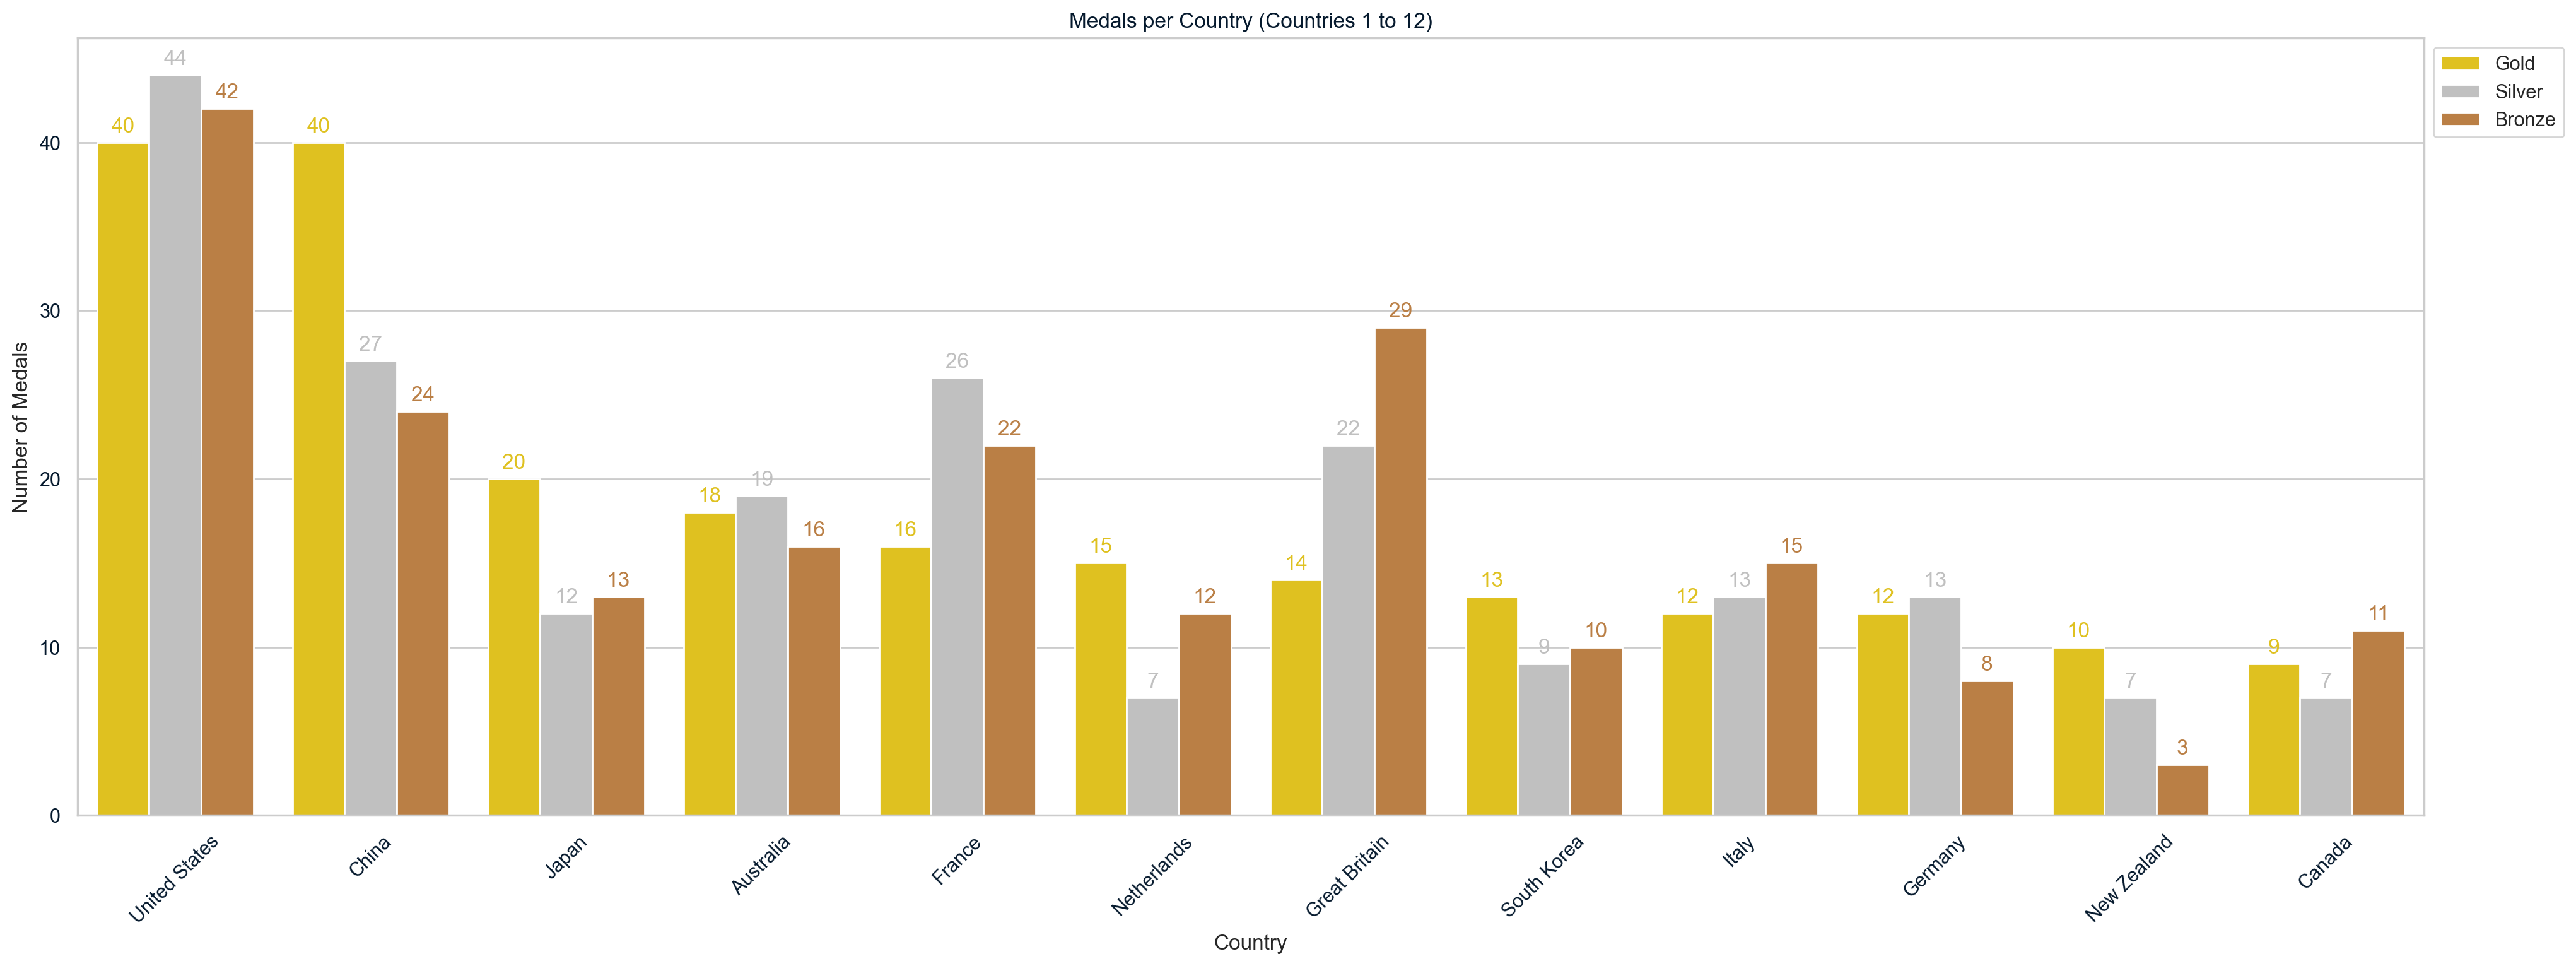

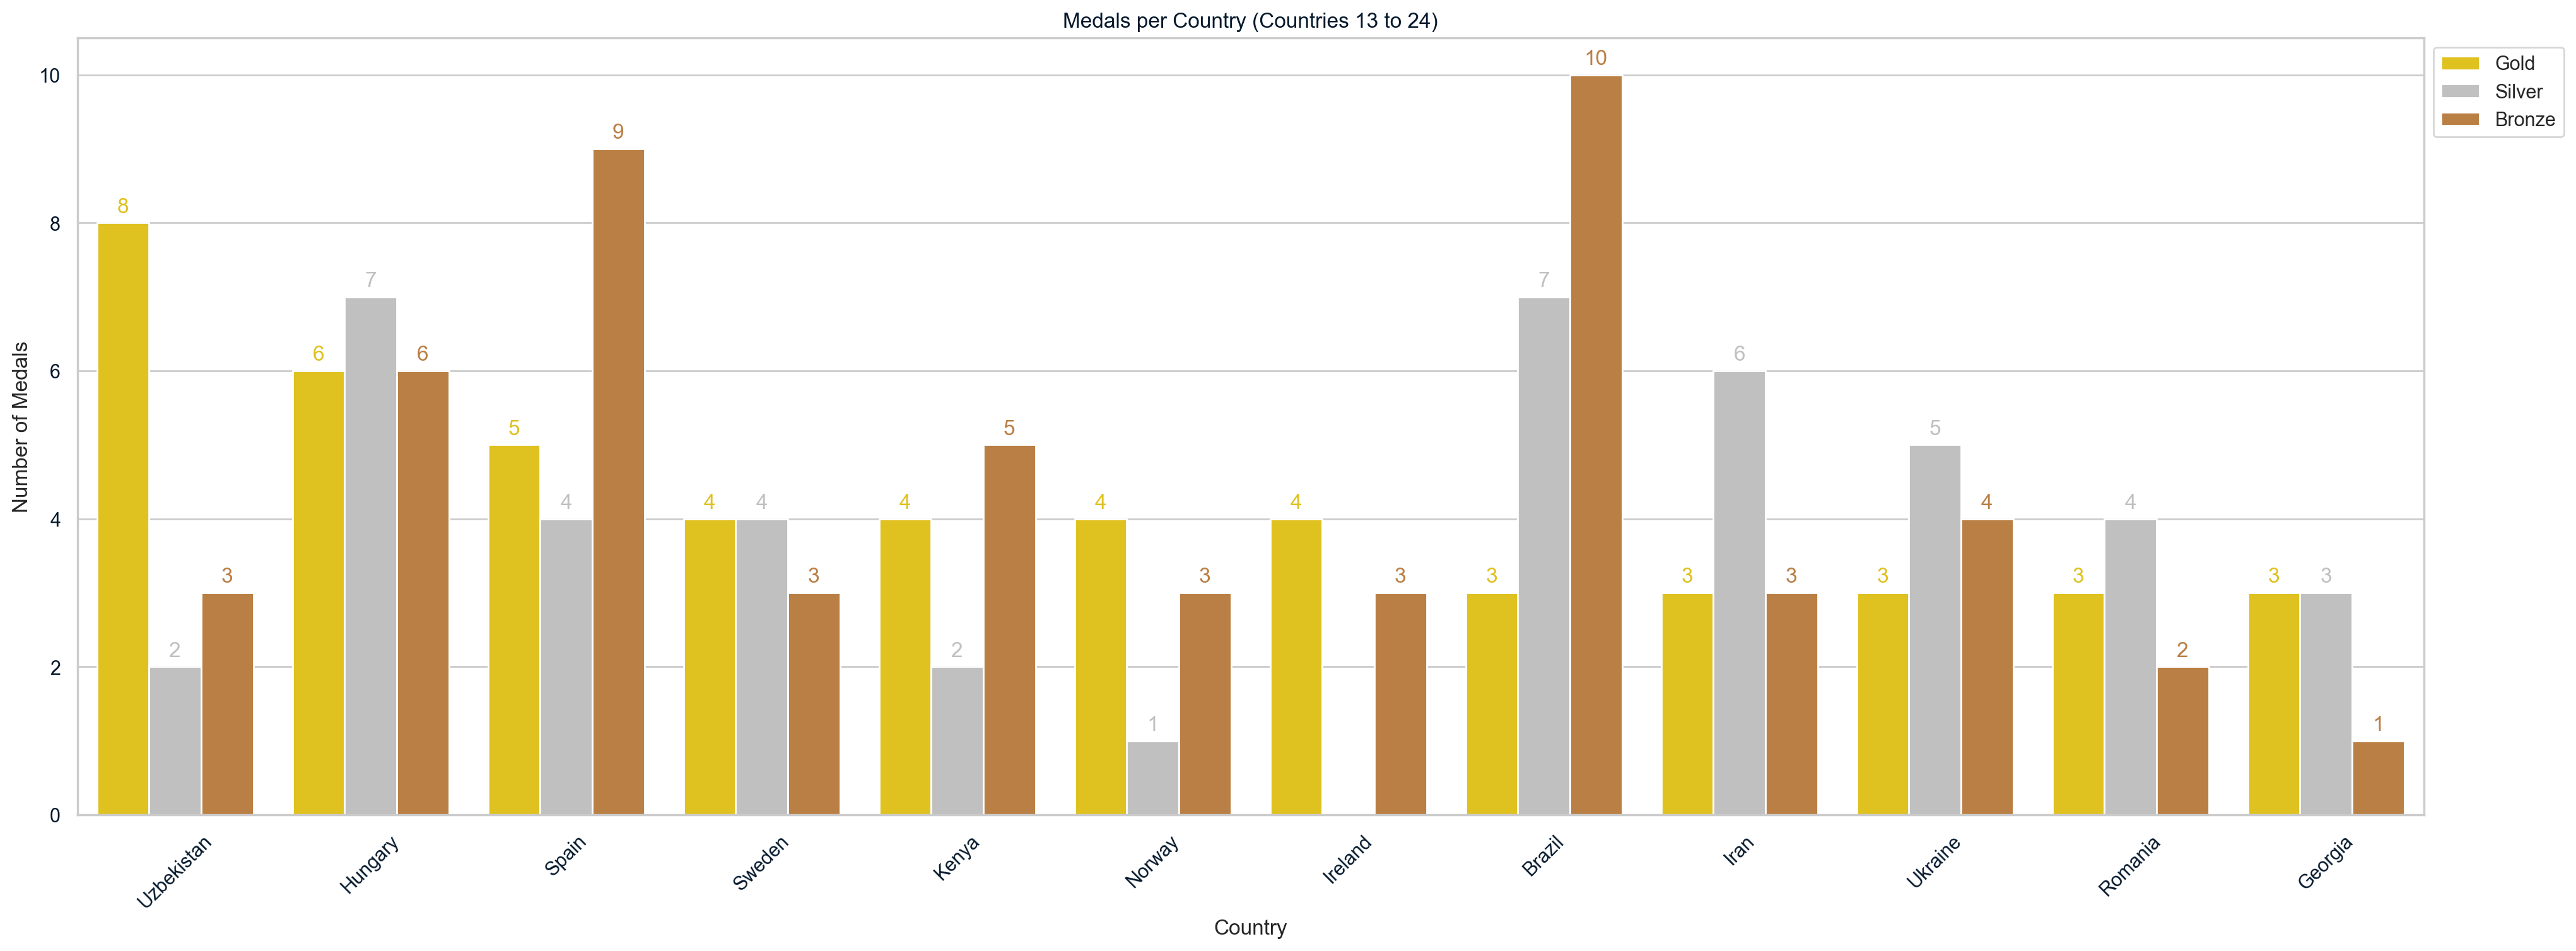

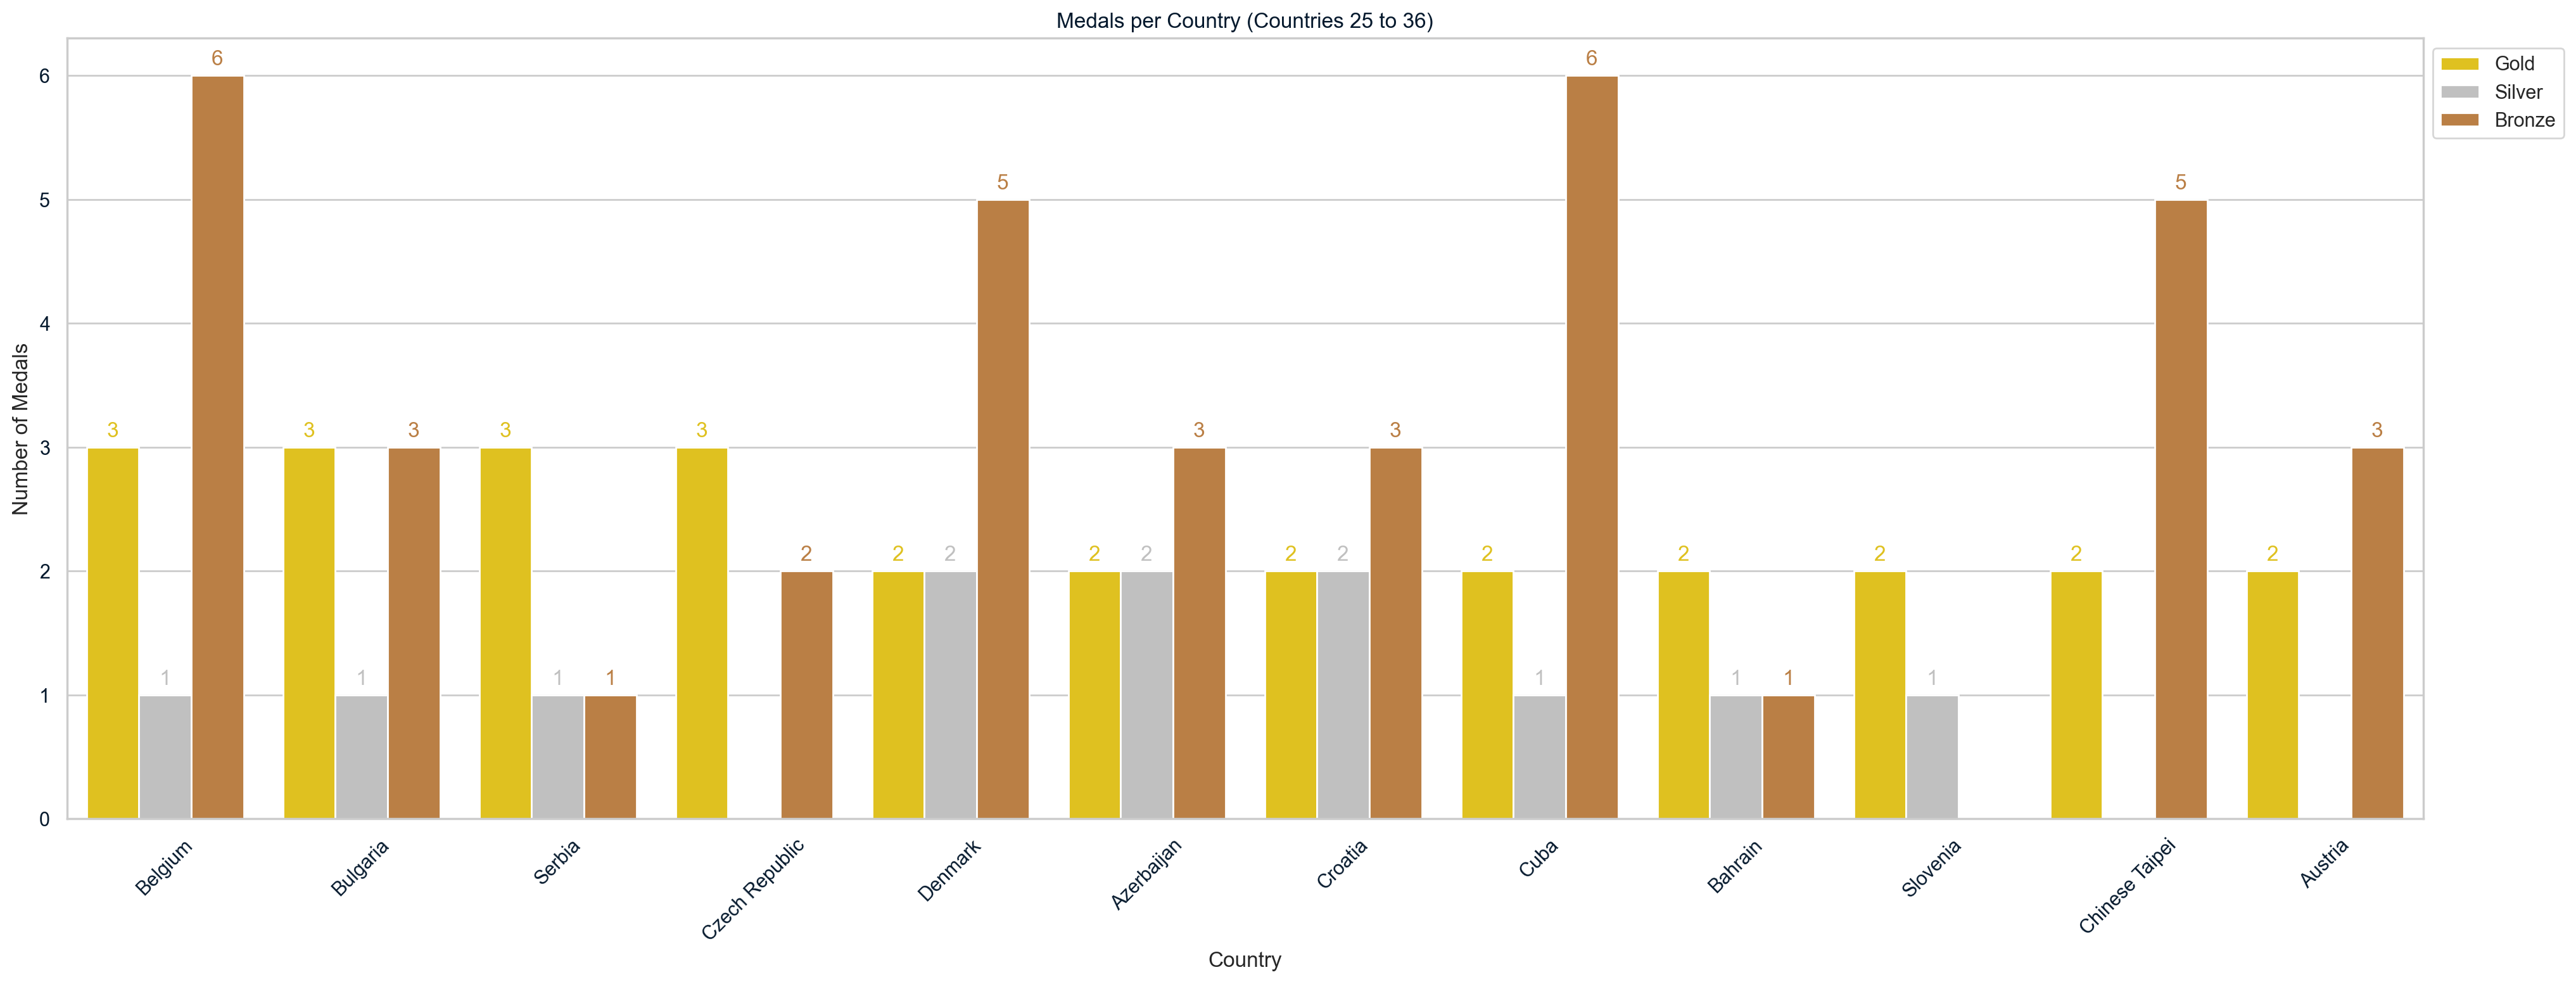

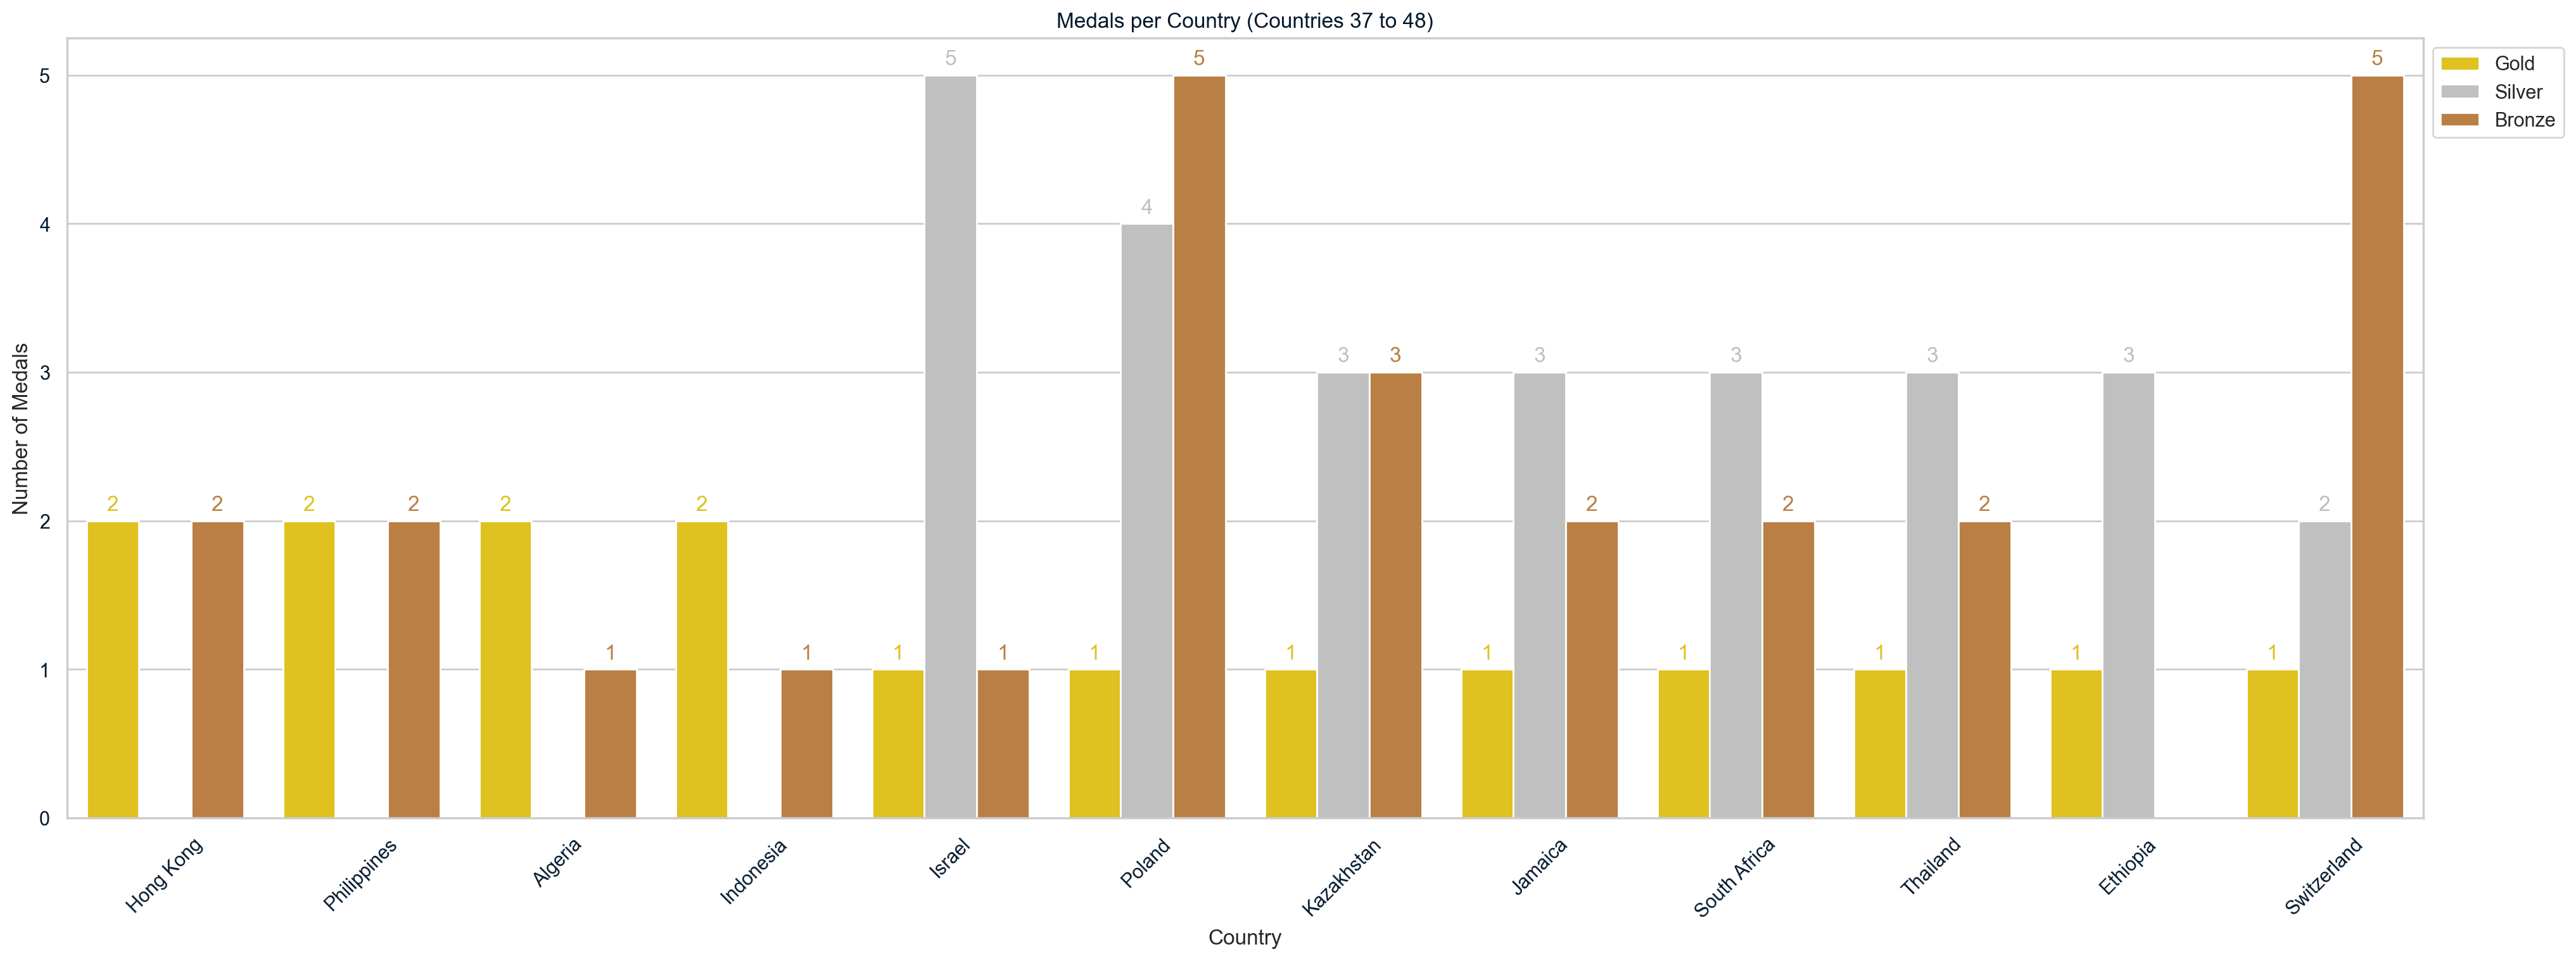

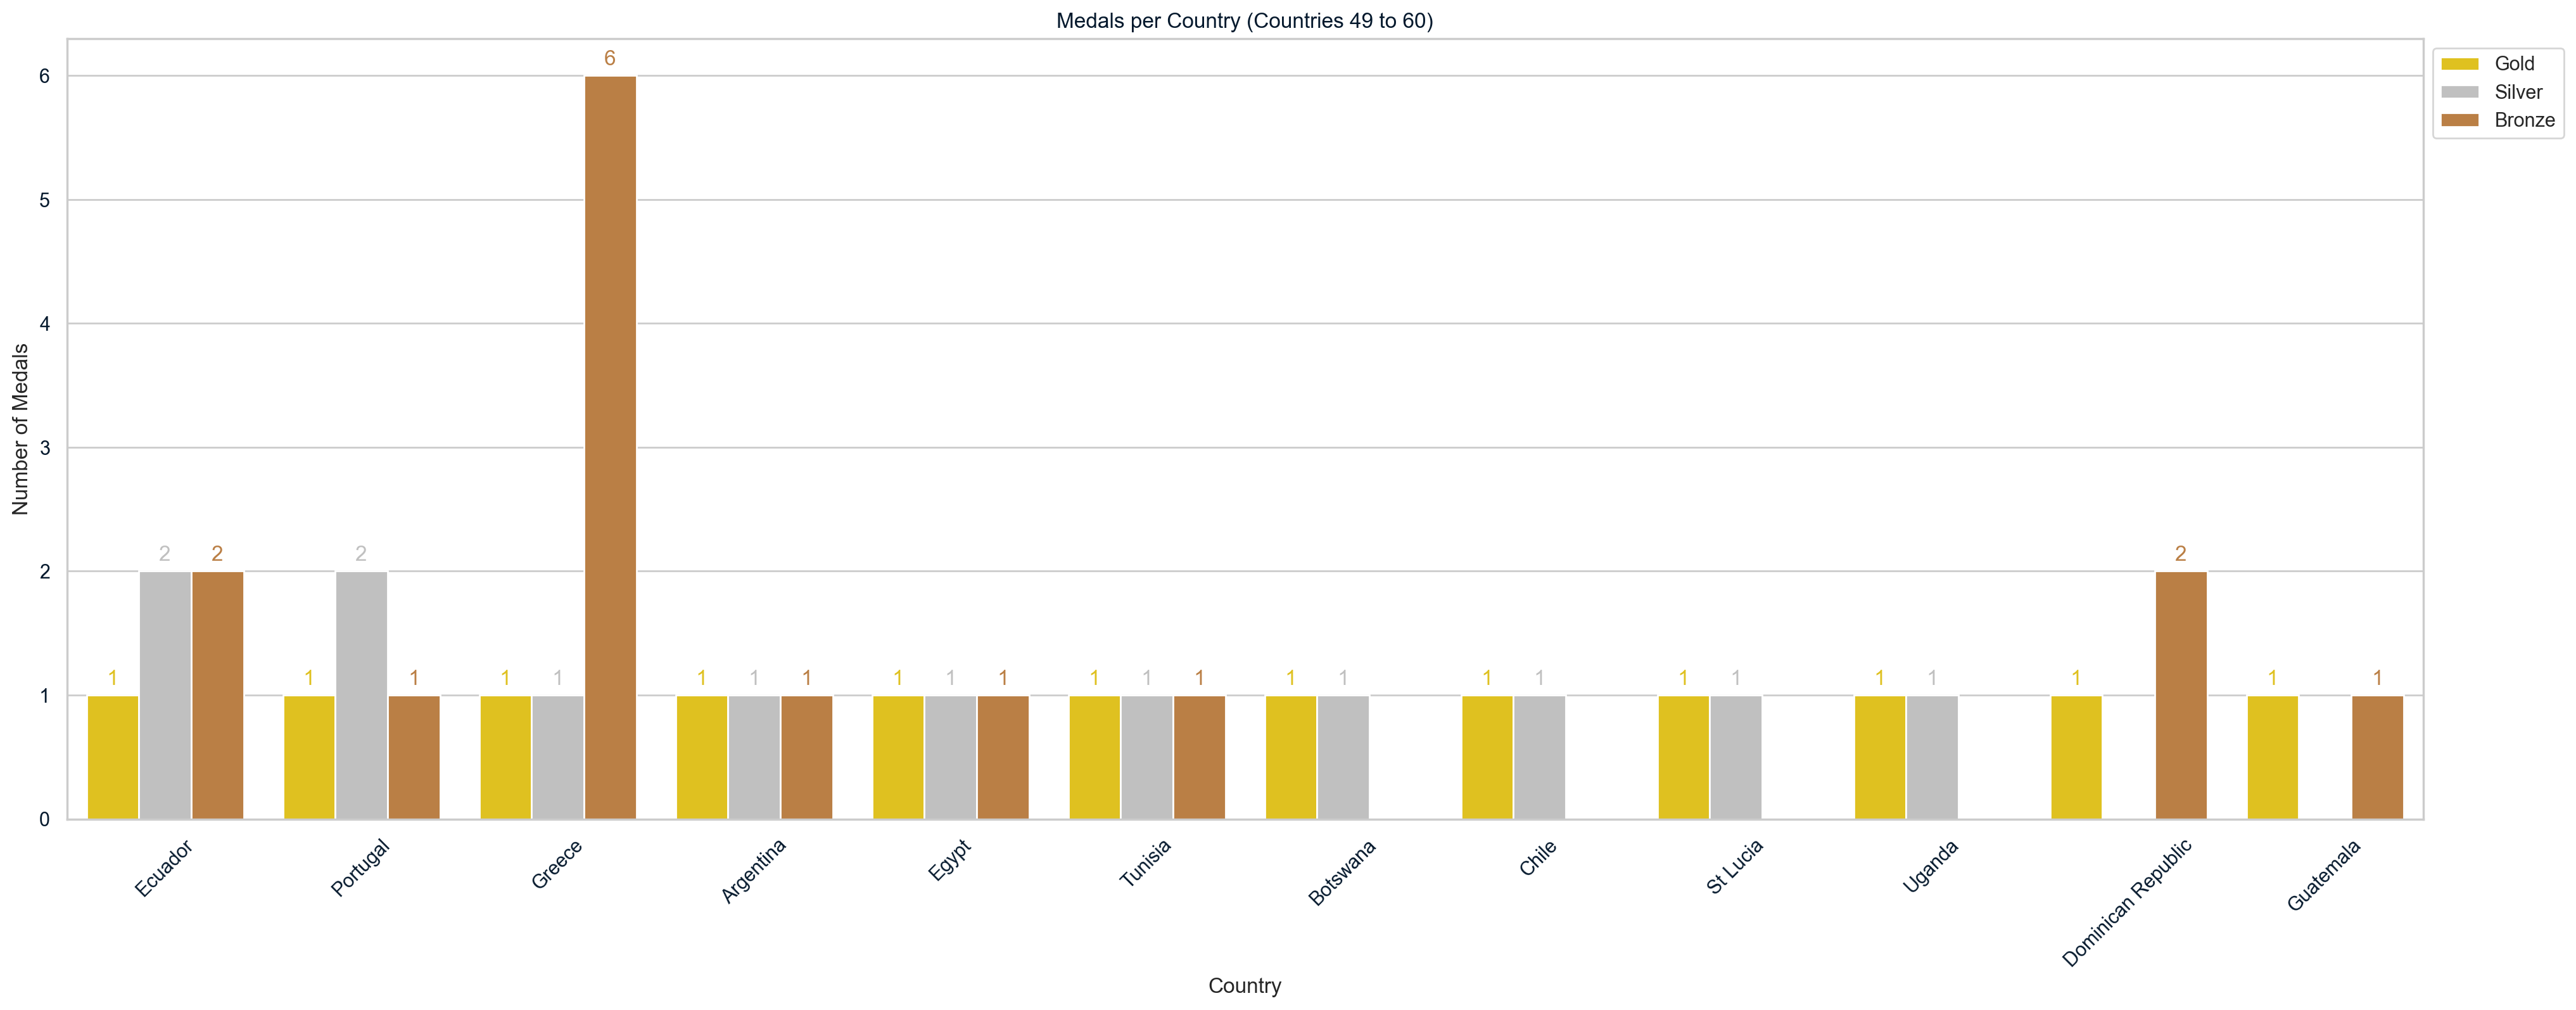

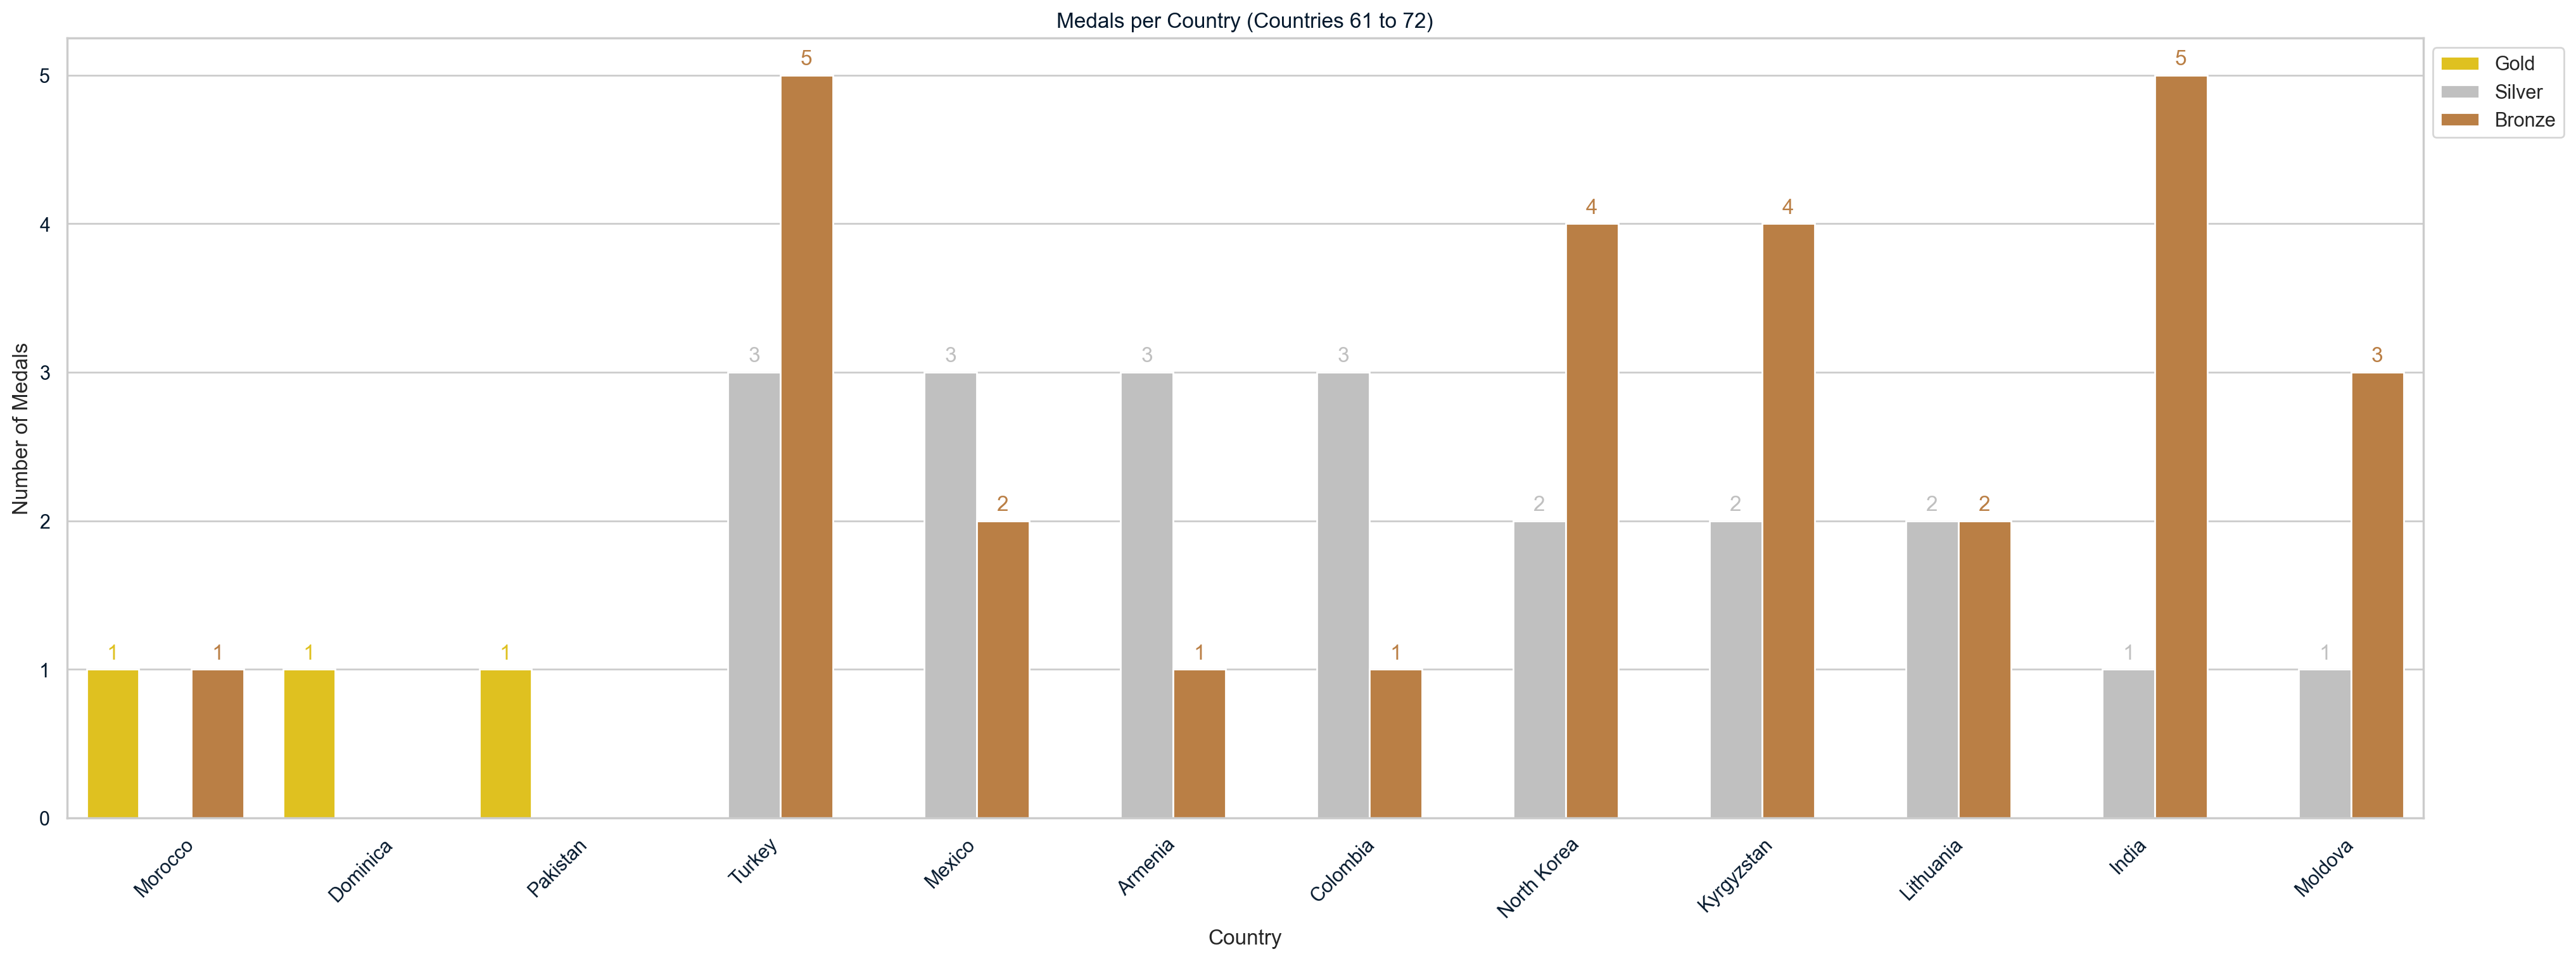

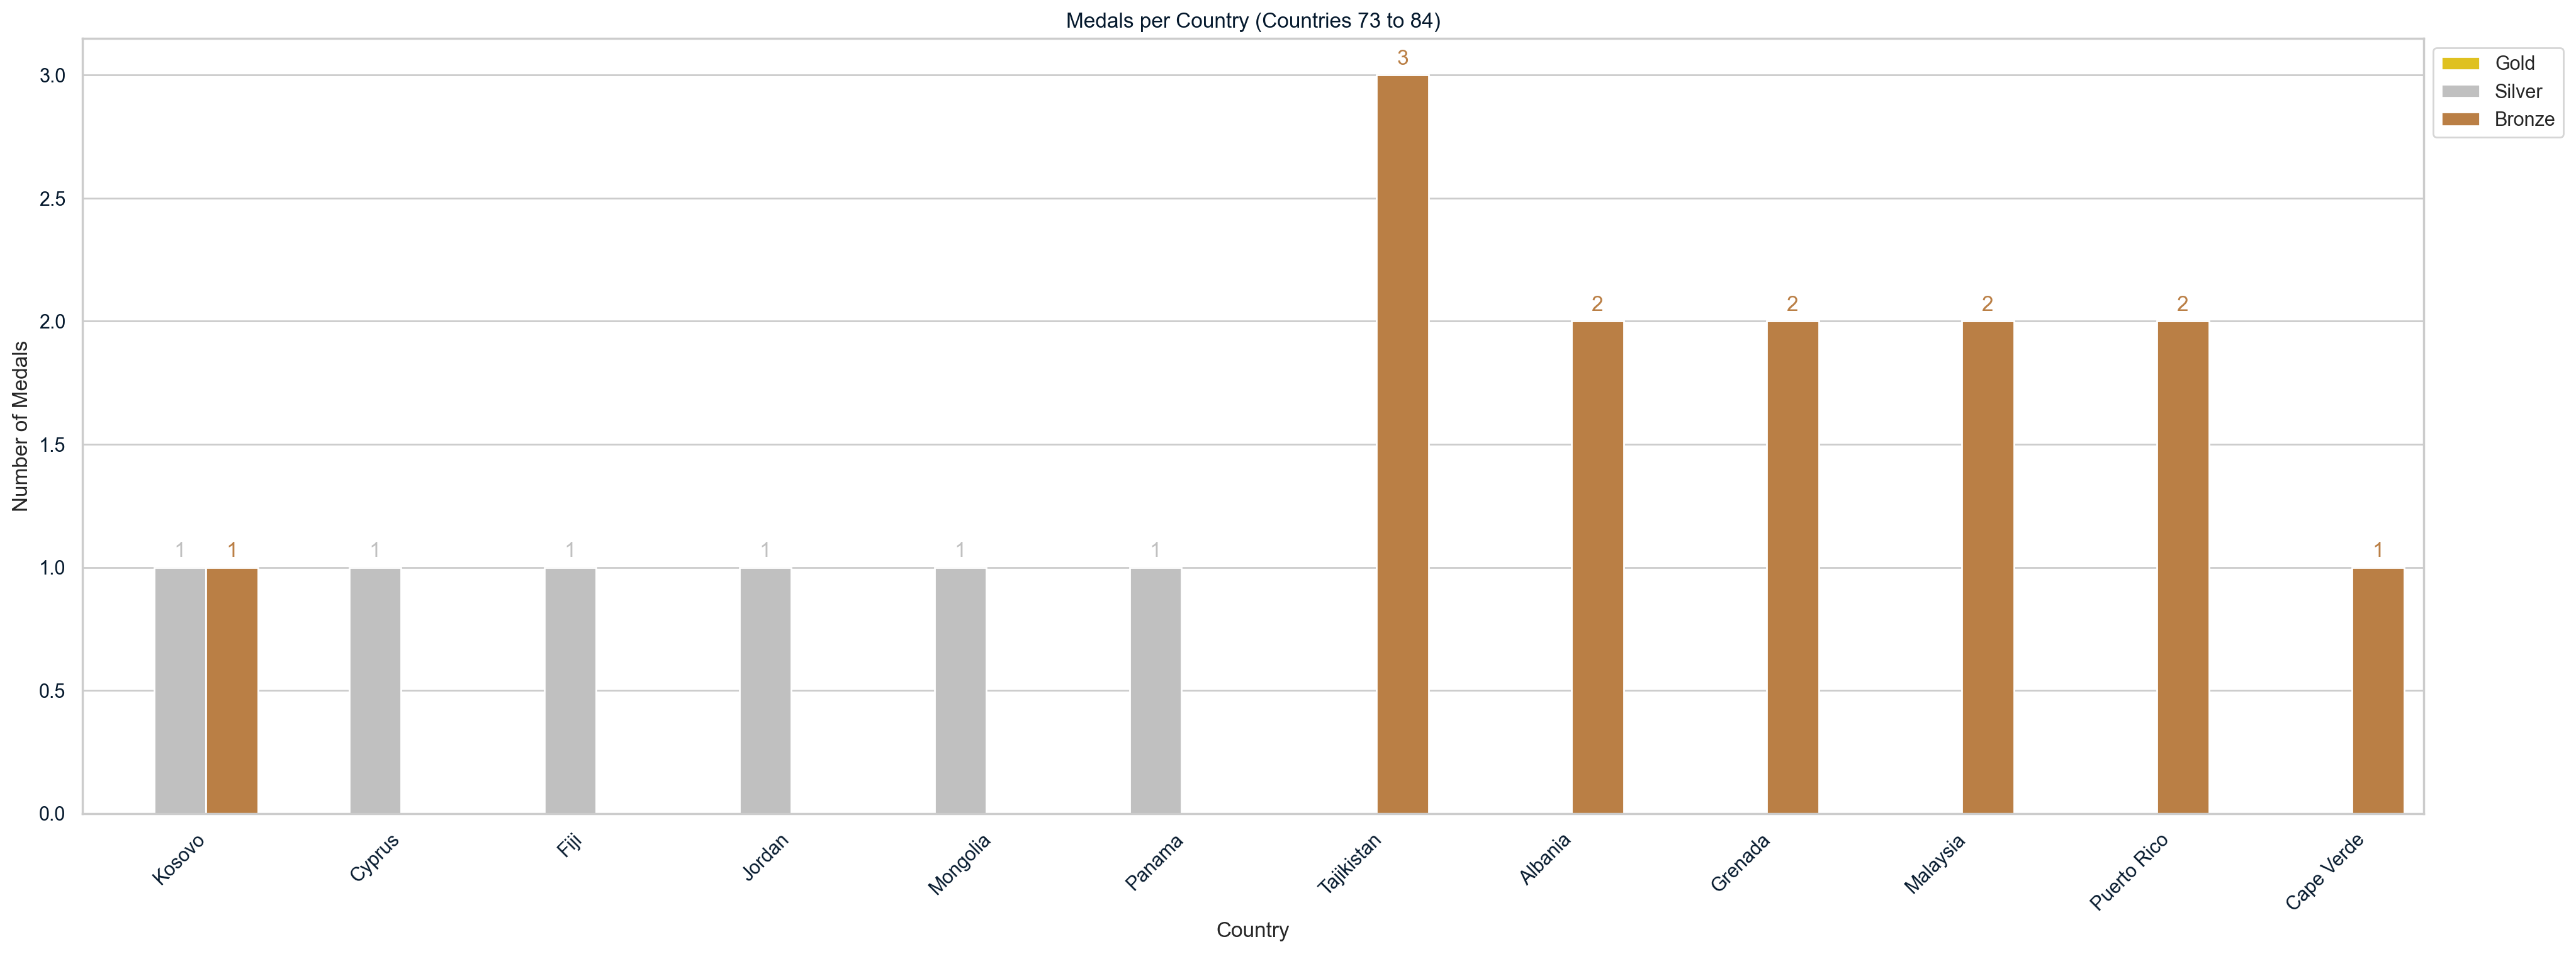

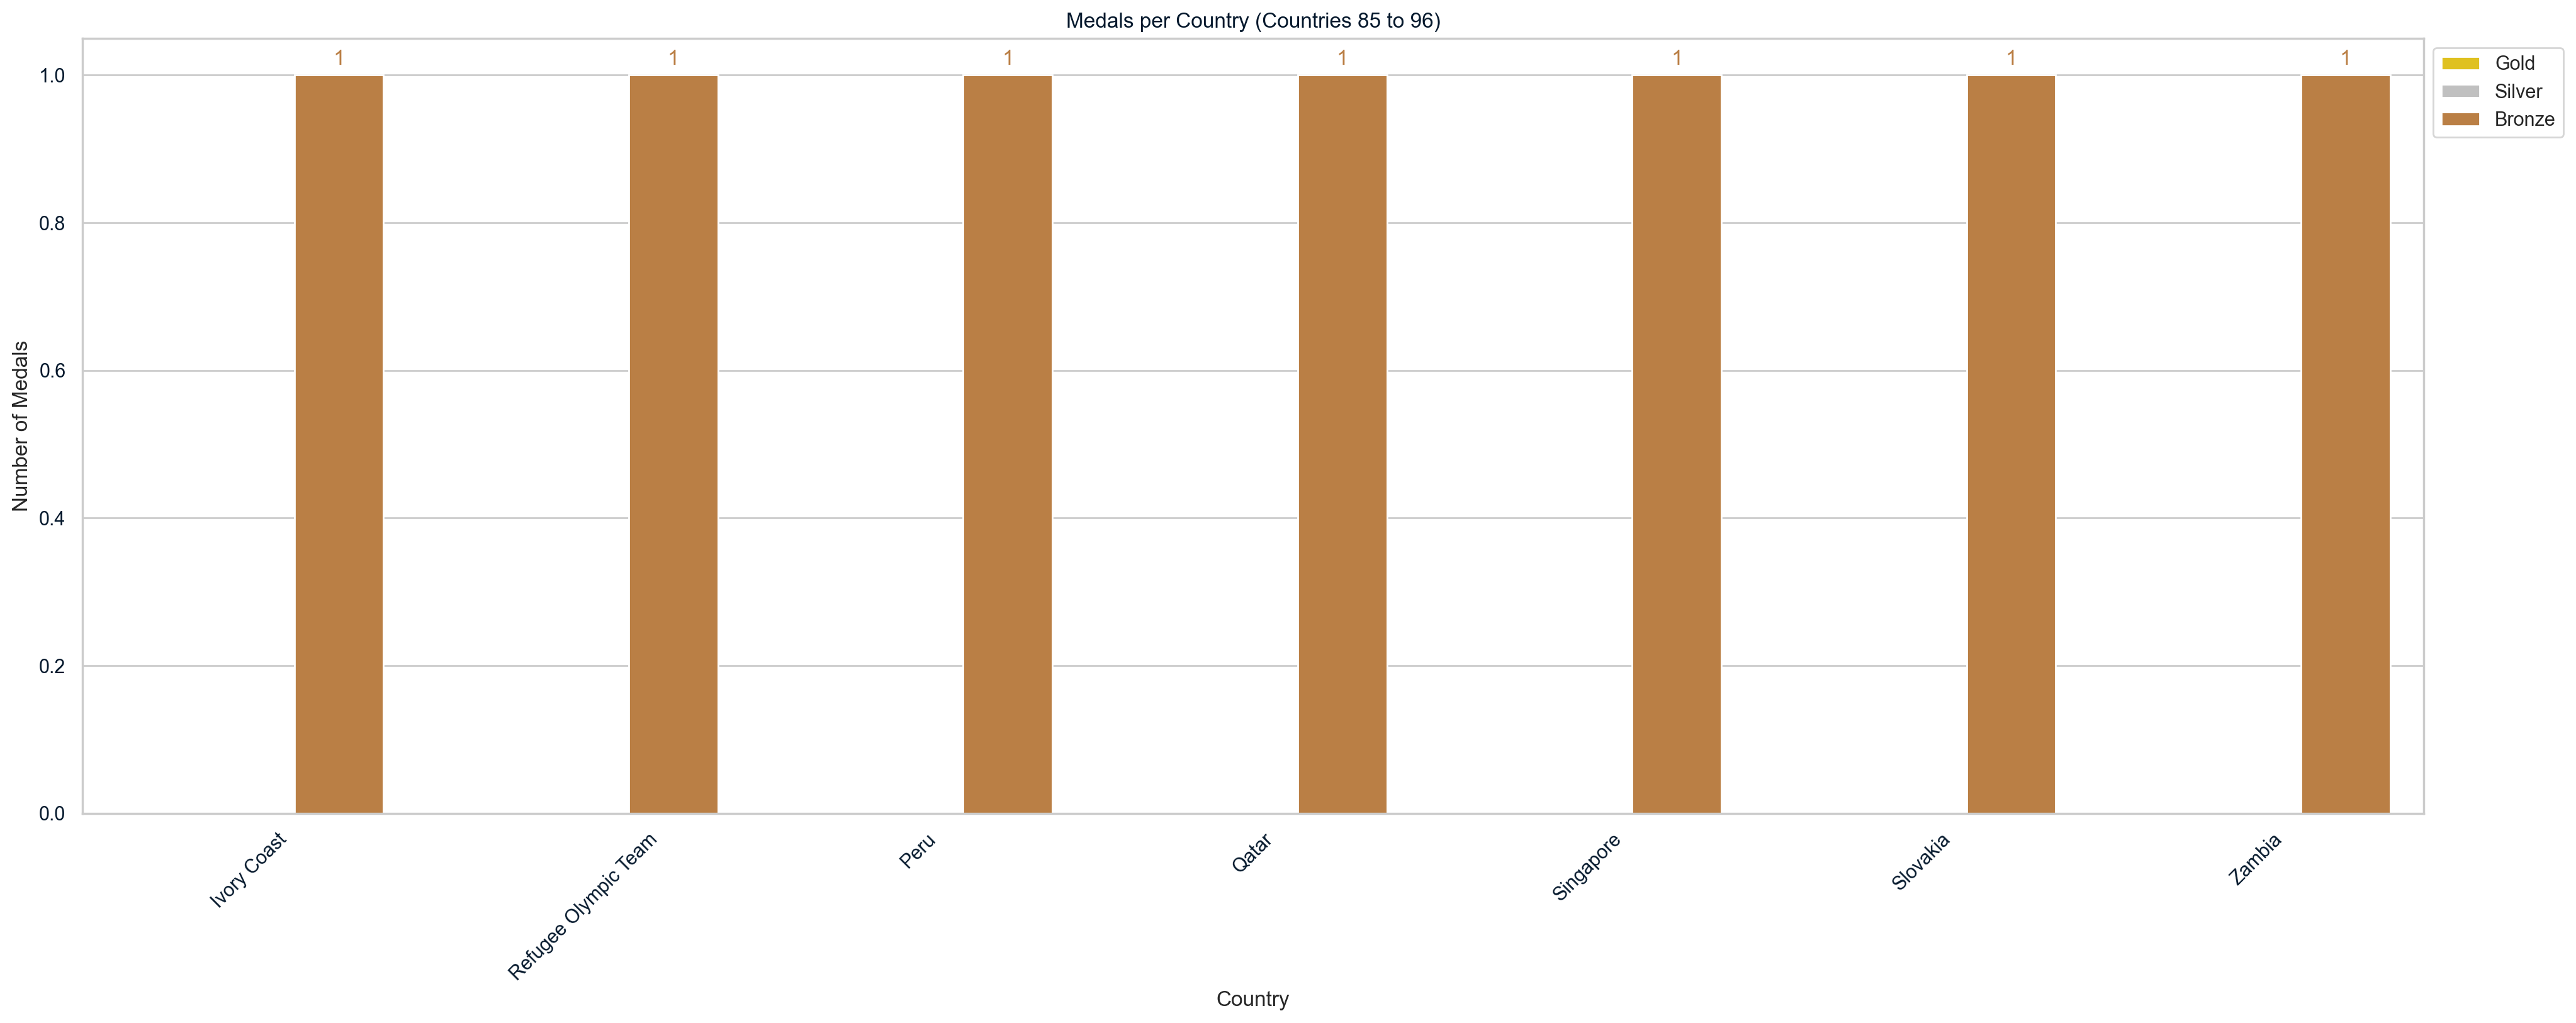

In [17]:
plot_medals_per_country(olympics_2024)

#### 2. Medal Distributios

KeyboardInterrupt: 

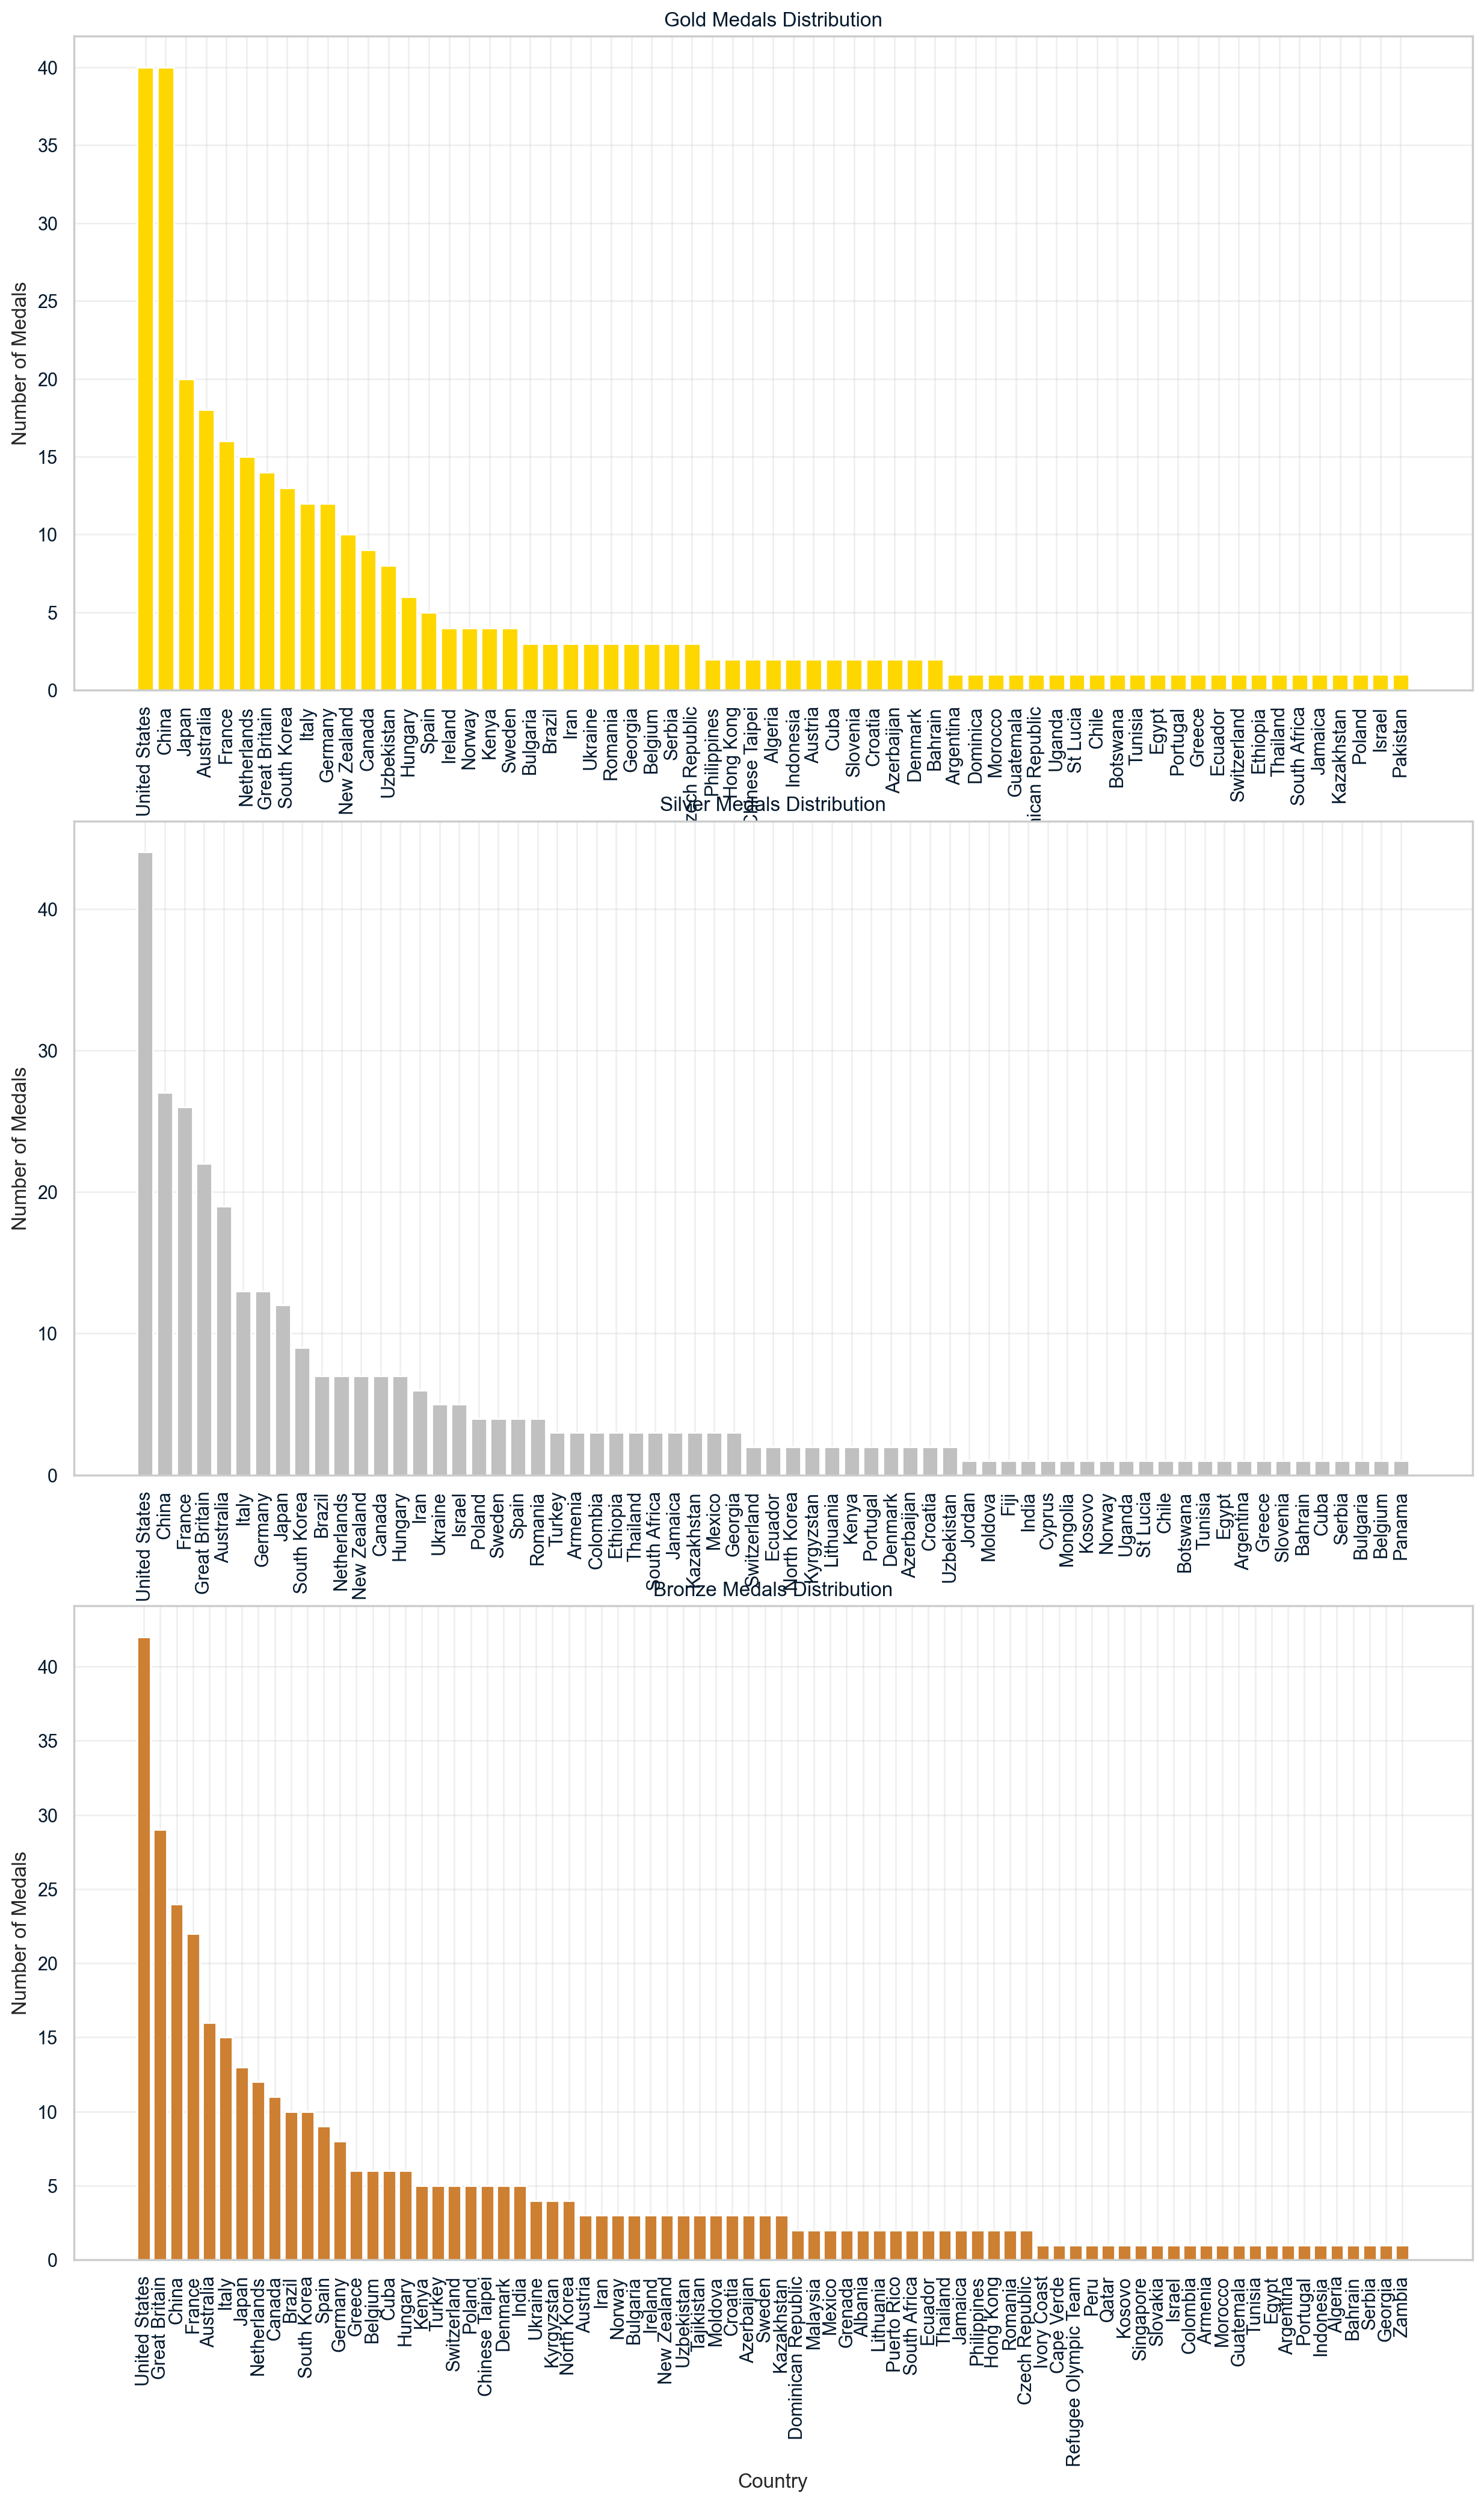

In [18]:
medal_types = ['Gold', 'Silver', 'Bronze']
colors = ['#FFD700', '#C0C0C0', '#CD7F32']
figsize_x = 15
figsize_y = 24

plot_medal_distribution(olympics_2024, medal_types=medal_types, colors=colors, figsize=(figsize_x, figsize_y))

#### 3. Medal Count Map

**Insights**:
The 2024 Olympics saw a significant number of European countries participating and winning medals. This can be attributed to several factors. Firstly, European countries have a long history of success in the Olympics, with well-established sports programs and infrastructure. Additionally, many European nations invest heavily in sports development, training facilities, and athlete support programs. Europe also has a diverse range of countries with different strengths in various sports, leading to a broad medal distribution. Furthermore, higher population and GDP in many European countries provide a larger pool of potential athletes and better resources for training and development. Lastly, sports are an integral part of European culture, with a strong emphasis on physical education and competitive sports from a young age. These factors combined contribute to the high medal count for European countries in the 2024 Olympics.

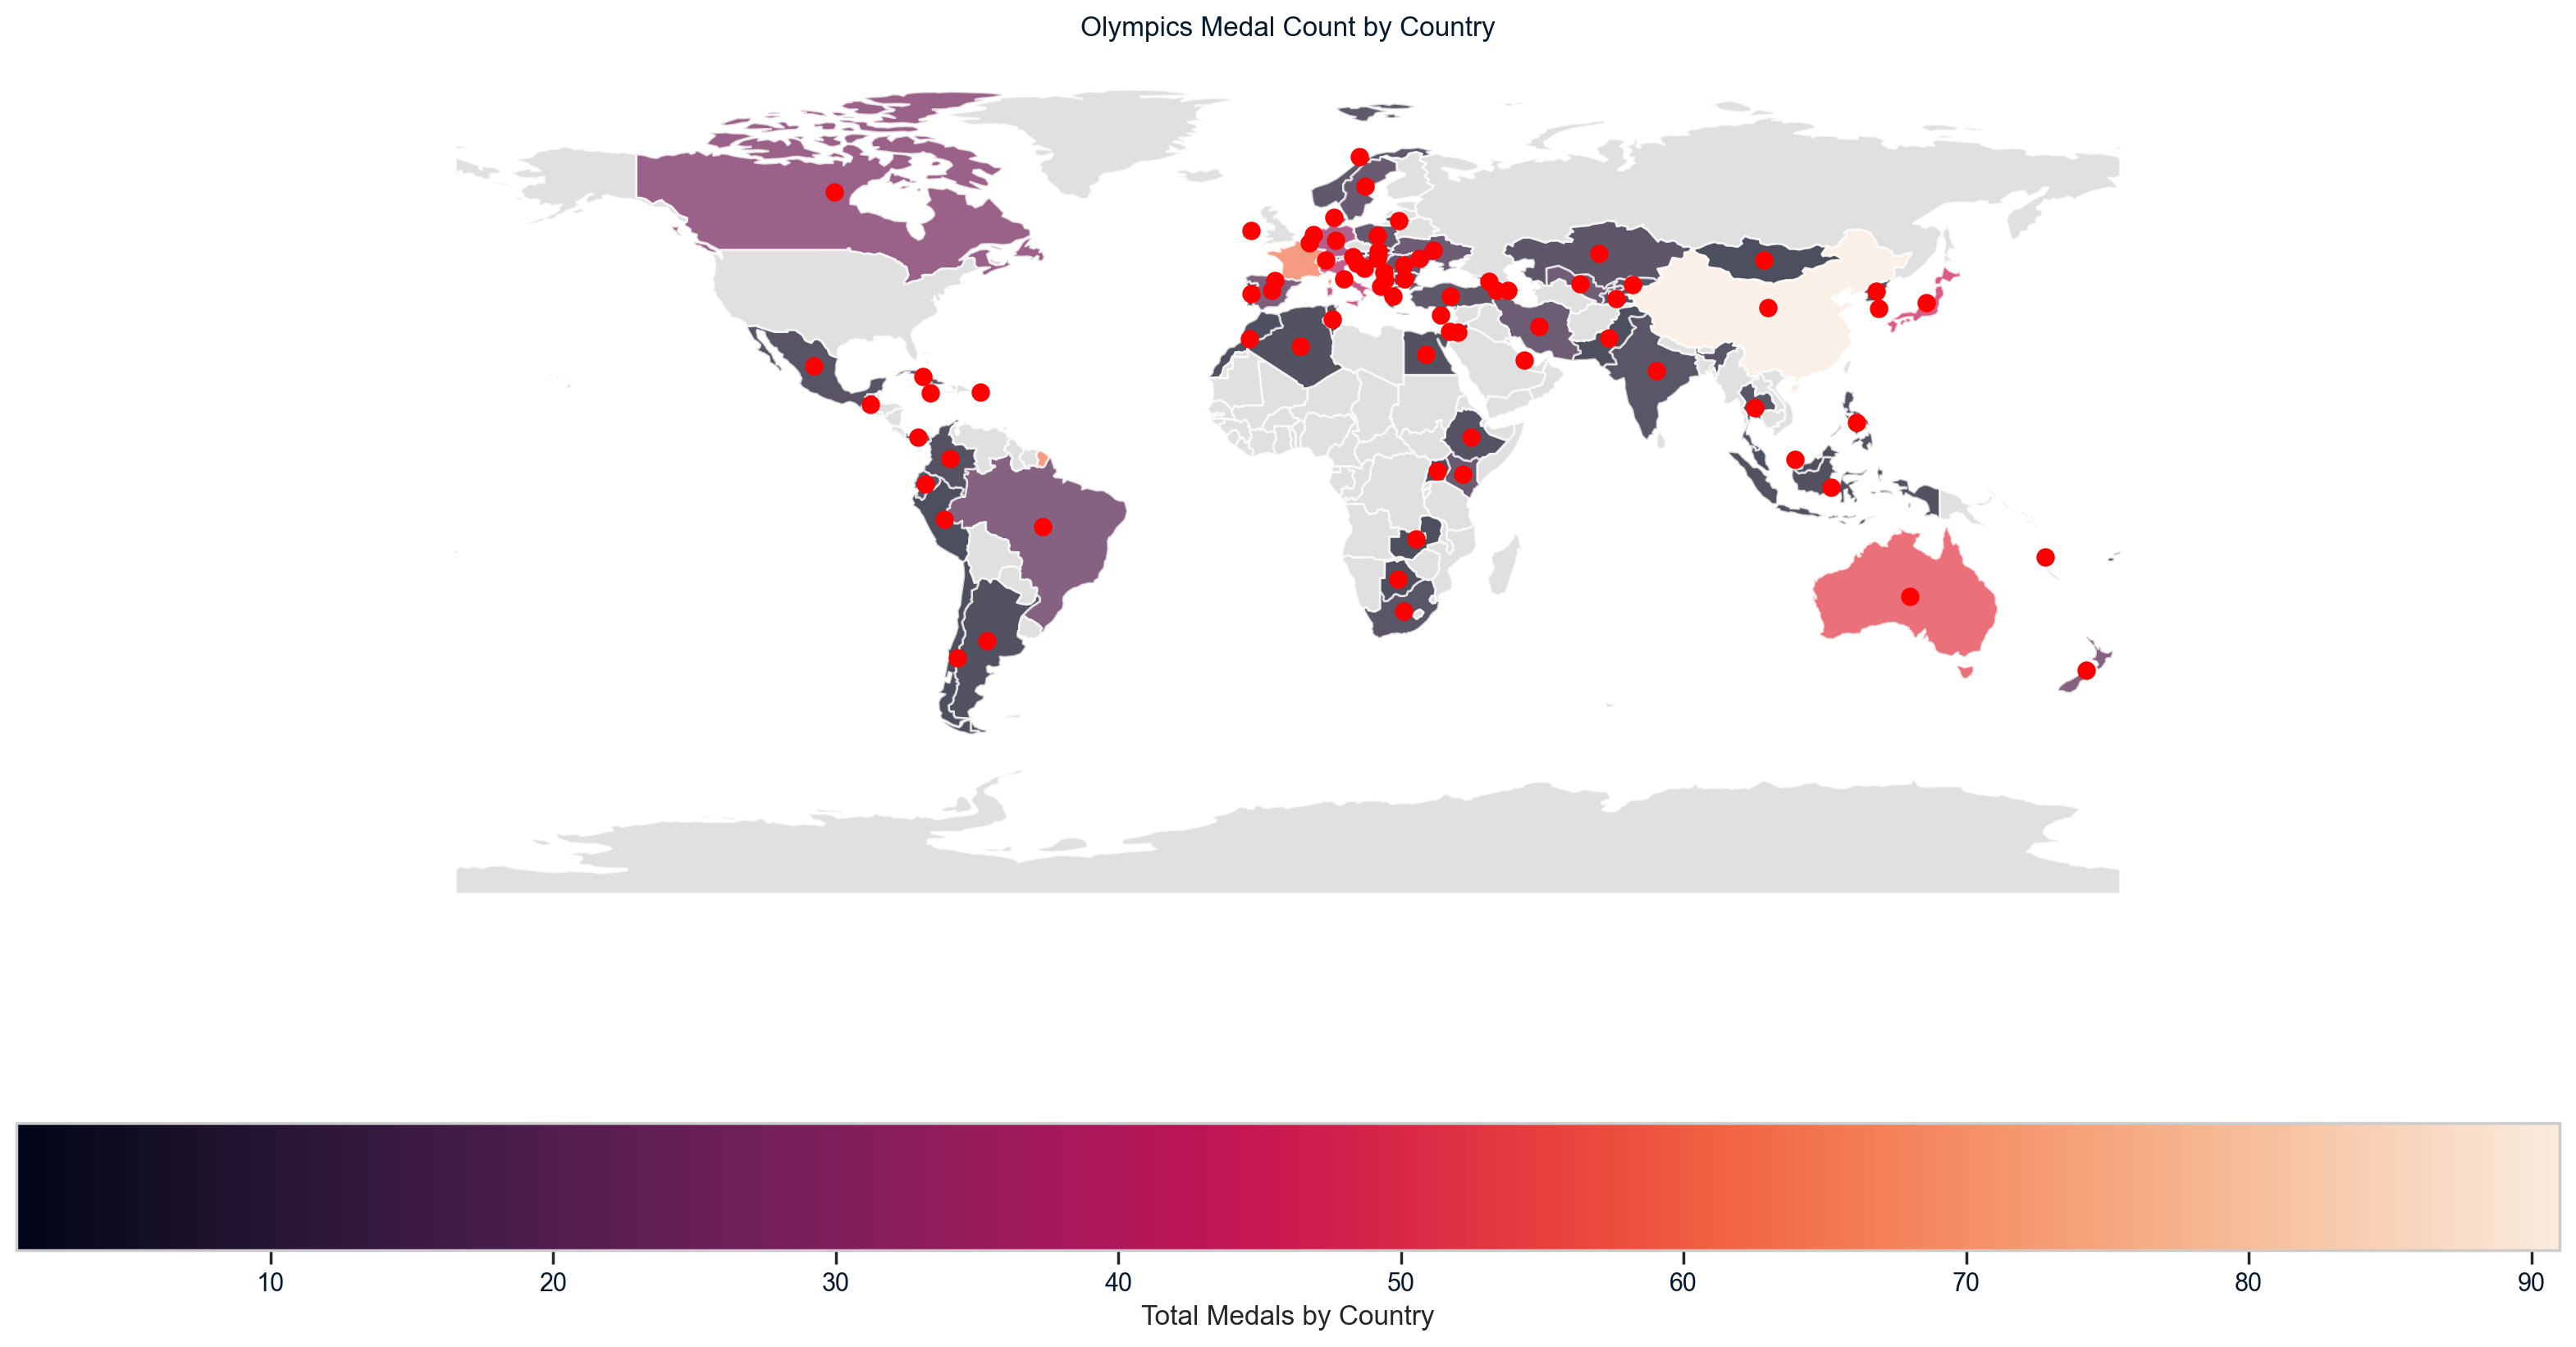

In [19]:
figsize_x = 20
figsize_y = 10

plot_olympic_medal_map(olympics_2024, figsize=(figsize_x, figsize_y))

#### 4. Top 10 Countries by Total Medals

**Insights**: The graph highlights the competitive nature of the Olympics and the efforts of top-performing countries to excel on the global stage.

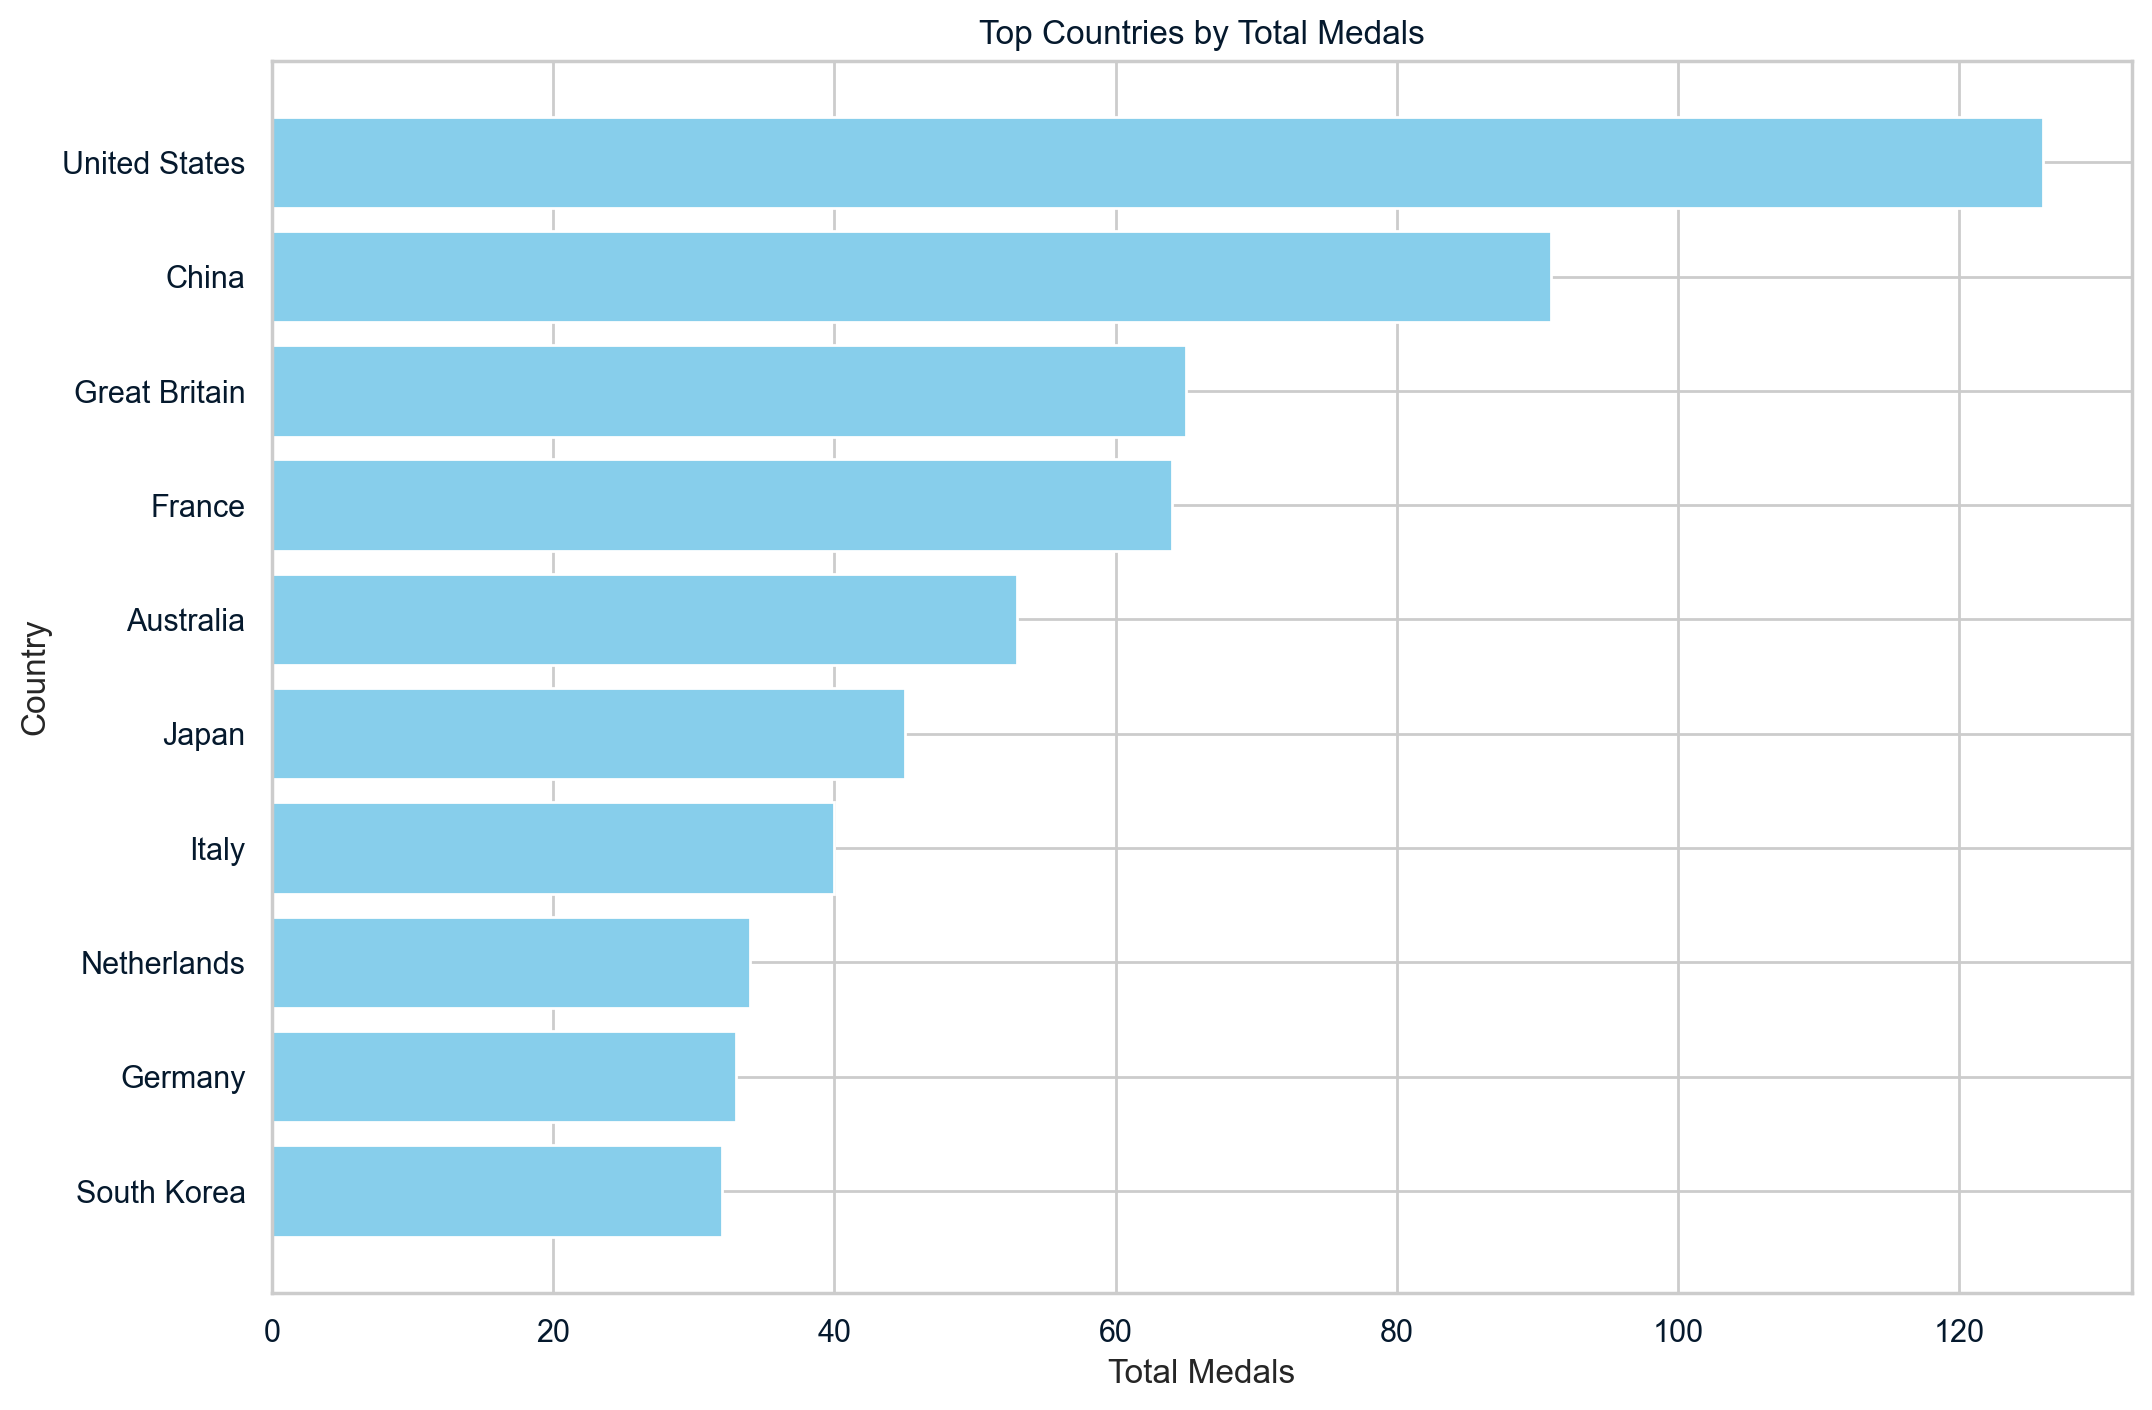

In [20]:
n = 10
figsize_x = 12
figsize_y = 8

plot_top_countries_by_medals(olympics_2024, n, figsize=(figsize_x, figsize_y))

#### **5. Country Performance Comparison** 

**Insight**: The graph provides a clear visualization of the top-performing countries in the 2024 Olympics, highlighting the competitive nature of the event and the global distribution of athletic talent.

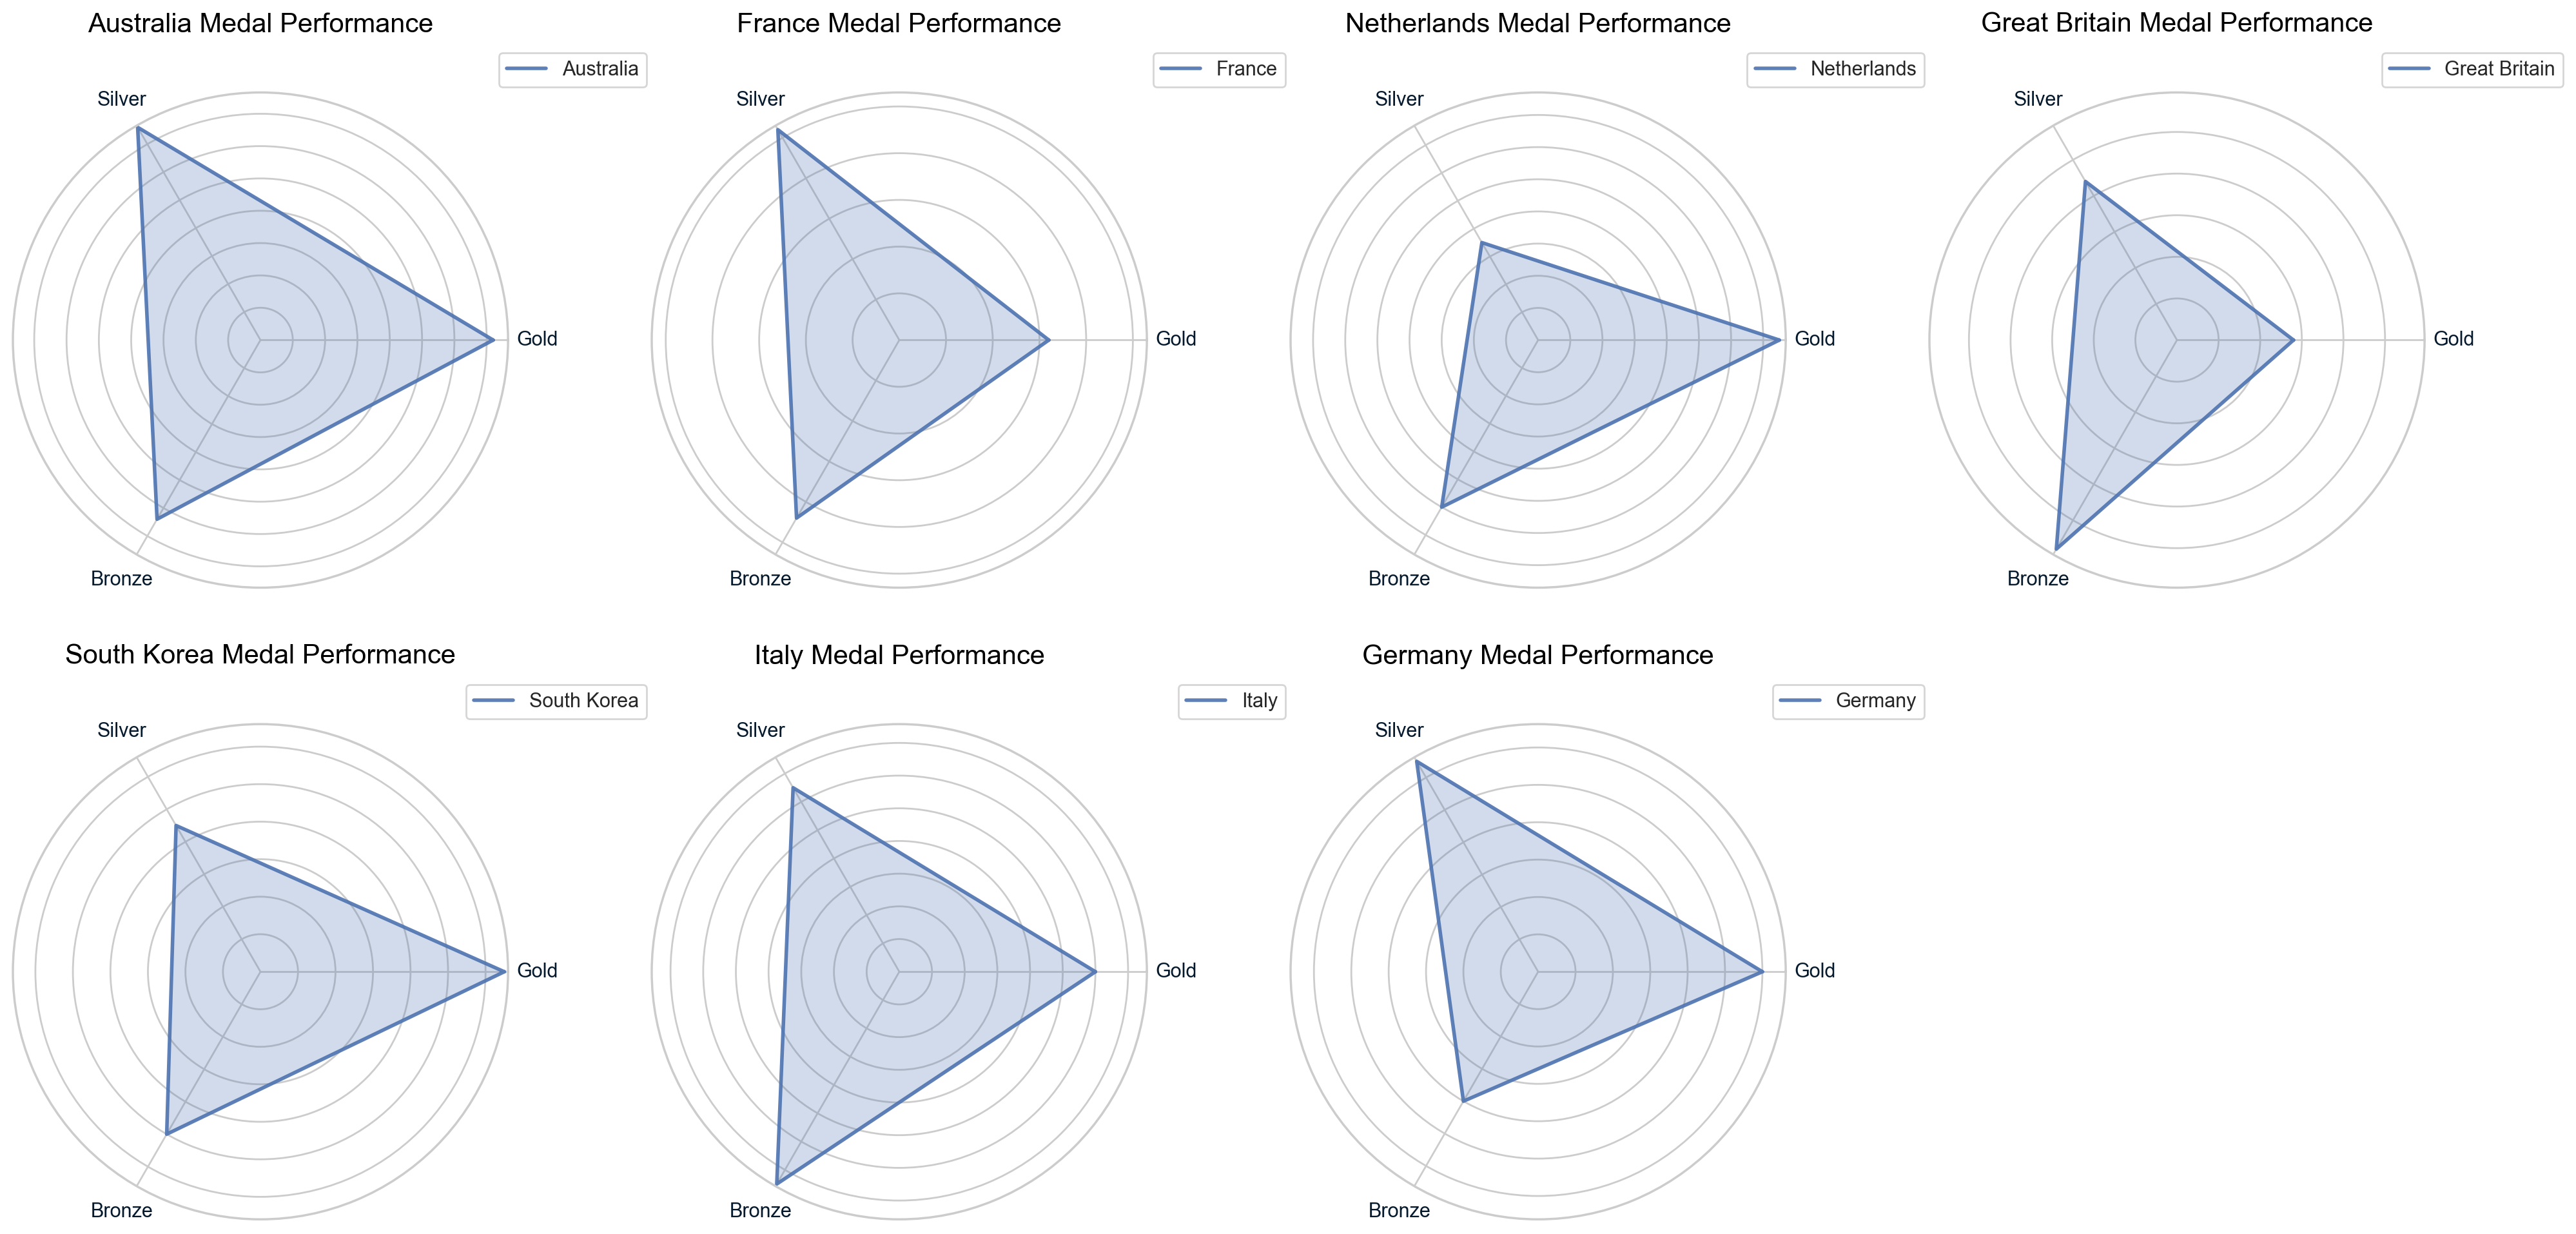

In [21]:
selected_countries = olympics_2024['Country'].head(10).tolist()
categories=['Gold', 'Silver', 'Bronze']
figsize_x = 20
figsize_y = 10

plot_country_medal_performance_radar(olympics_2024, selected_countries=selected_countries, categories=categories, figsize=(figsize_x, figsize_y))

## IV. Investigate Olympics 1896 to 2020

### A. Load and Preview the Dataset

In [22]:
# Load the dataset
olympics_1896_2020 = pd.read_csv(olympics_1896_2020_url)

# Preview the first five rows
olympics_1896_2020.head()

Year Host_country Host_city  ... Gold Silver  Bronze
0  1896       Greece    Athens  ...    2      3       2
1  1896       Greece    Athens  ...    2      1       3
2  1896       Greece    Athens  ...    5      4       2
3  1896       Greece    Athens  ...   11      7       2
4  1896       Greece    Athens  ...    6      5       2

[5 rows x 8 columns]

### B. Exploratory Data Analysis

#### i. Data Cleaning

In [23]:
olympics_1896_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Year          1344 non-null   int64 
 1   Host_country  1344 non-null   object
 2   Host_city     1344 non-null   object
 3   Country_Name  1344 non-null   object
 4   Country_Code  1258 non-null   object
 5   Gold          1344 non-null   int64 
 6   Silver        1344 non-null   int64 
 7   Bronze        1344 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 84.1+ KB


In [24]:
olympics_1896_2020.isnull().sum()

Year             0
Host_country     0
Host_city        0
Country_Name     0
Country_Code    86
Gold             0
Silver           0
Bronze           0
dtype: int64

In [25]:
olympics_1896_2020.duplicated().sum()

0

#### ii. Statistical Summary

In [26]:
olympics_1896_2020.describe()

Year         Gold       Silver       Bronze
count  1344.000000  1344.000000  1344.000000  1344.000000
mean   1978.958333     4.069196     4.037946     4.389137
std      33.482213     8.448017     7.095197     6.843179
min    1896.000000     0.000000     0.000000     0.000000
25%    1956.000000     0.000000     0.000000     1.000000
50%    1988.000000     1.000000     2.000000     2.000000
75%    2008.000000     4.000000     4.000000     5.000000
max    2020.000000    83.000000    78.000000    77.000000

### C. Data Preprocessing

#### i. Rename Columns

To ensure consistency across our datasets, we need to rename the columns in the `olympics_1896_2020` dataframe to follow the same format as the `olympics_2024` dataset. Specifically, we need to change the column names as follows:

- "Host_country" to "Host Country"
- "Host_city" to "Host City"
- "Country_Name" to "Country"
- "Country_Code" to "Country Code"

---

- Rename the columns
- Preview the processed dataset

In [27]:
# Rename columns in the olympics_1896_2020 dataframe to match the format of the olympics_2024 dataframe
olympics_1896_2020.rename(columns={
    "Host_country": "Host Country",
    "Host_city": "Host City",
    "Country_Name": "Country",
    "Country_Code": "Country Code"
}, inplace=True)

# Display the first few rows of the dataframe to verify the changes
olympics_1896_2020.head()

Year Host Country Host City  ... Gold Silver  Bronze
0  1896       Greece    Athens  ...    2      3       2
1  1896       Greece    Athens  ...    2      1       3
2  1896       Greece    Athens  ...    5      4       2
3  1896       Greece    Athens  ...   11      7       2
4  1896       Greece    Athens  ...    6      5       2

[5 rows x 8 columns]

#### ii. Remove Column

Since the `Country Code` column can be removed because it does not have a significant impact on the analysis. The `Country` column already provides the necessary information to identify each country, making the `Country Code` column redundant. Removing this column will help simplify the dataset and make the analysis more straightforward.

- Remove the column `Country Code`
- Preview processed dataset

In [28]:
# Remove the column
olympics_1896_2020 = olympics_1896_2020.drop(columns=['Country Code'])

# Preview the dataset
olympics_1896_2020.head()

Year Host Country Host City        Country  Gold  Silver  Bronze
0  1896       Greece    Athens  Great Britain     2       3       2
1  1896       Greece    Athens        Hungary     2       1       3
2  1896       Greece    Athens         France     5       4       2
3  1896       Greece    Athens  United States    11       7       2
4  1896       Greece    Athens        Germany     6       5       2

## V. Data Preprocess

### A. Investigate the Datasets

- Identify the unique countries covered in the `olympics_2024` dataset.

In [29]:
unique_countries_2024 = olympics_2024['Country'].unique()
print(unique_countries_2024)

['United States' 'China' 'Japan' 'Australia' 'France' 'Netherlands'
 'Great Britain' 'South Korea' 'Italy' 'Germany' 'New Zealand' 'Canada'
 'Uzbekistan' 'Hungary' 'Spain' 'Sweden' 'Kenya' 'Norway' 'Ireland'
 'Brazil' 'Iran' 'Ukraine' 'Romania' 'Georgia' 'Belgium' 'Bulgaria'
 'Serbia' 'Czech Republic' 'Denmark' 'Azerbaijan' 'Croatia' 'Cuba'
 'Bahrain' 'Slovenia' 'Chinese Taipei' 'Austria' 'Hong Kong' 'Philippines'
 'Algeria' 'Indonesia' 'Israel' 'Poland' 'Kazakhstan' 'Jamaica'
 'South Africa' 'Thailand' 'Ethiopia' 'Switzerland' 'Ecuador' 'Portugal'
 'Greece' 'Argentina' 'Egypt' 'Tunisia' 'Botswana' 'Chile' 'St Lucia'
 'Uganda' 'Dominican Republic' 'Guatemala' 'Morocco' 'Dominica' 'Pakistan'
 'Turkey' 'Mexico' 'Armenia' 'Colombia' 'North Korea' 'Kyrgyzstan'
 'Lithuania' 'India' 'Moldova' 'Kosovo' 'Cyprus' 'Fiji' 'Jordan'
 'Mongolia' 'Panama' 'Tajikistan' 'Albania' 'Grenada' 'Malaysia'
 'Puerto Rico' 'Cape Verde' 'Ivory Coast' 'Refugee Olympic Team' 'Peru'
 'Qatar' 'Singapore' 'Slovakia'

- Identify the unique countries covered in the `olympics_1896_2020` dataset.

In [30]:
unique_countries_1896_2020 = olympics_1896_2020['Country'].unique()
print(unique_countries_1896_2020)

['Great Britain' 'Hungary' 'France' 'United States' 'Germany' 'Austria'
 'Mixed team' 'Greece' 'Switzerland' 'Australia' 'Denmark' 'Italy' 'Cuba'
 'India' 'Netherlands' 'Bohemia' 'Belgium' 'Sweden' 'Spain' 'Canada'
 'Luxembourg' 'Norway' 'Australasia' 'Russian Empire' 'South Africa'
 'Finland' 'Brazil' 'Czechoslovakia' 'New Zealand' 'Japan' 'Estonia'
 'Haiti' 'Romania' 'Poland' 'Portugal' 'Argentina' 'Yugoslavia' 'Uruguay'
 'Philippines' 'Chile' 'Egypt' 'Ireland' 'Latvia' 'Mexico' 'Turkey'
 'Jamaica' 'Peru' 'South Korea' 'Trinidad and Tobago' 'Panama'
 'Puerto Rico' 'Iran' 'Ceylon' 'Soviet Union' 'Venezuela' 'Bulgaria'
 'Lebanon' 'Bahamas' 'Pakistan' 'Iceland' 'United Team of Germany'
 'Ethiopia' 'Singapore' 'Republic of China' 'Morocco'
 'British West Indies' 'Iraq' 'Ghana' 'Kenya' 'Nigeria' 'Tunisia'
 'East Germany' 'West Germany' 'Uganda' 'Cameroon' 'Mongolia'
 'North Korea' 'Niger' 'Colombia' 'Thailand' 'Bermuda' 'Tanzania'
 'Zimbabwe' 'Guyana' 'Zambia' 'Dominican Republic' 'China'

As observed, the dataset contains multiple instances of the same country with inconsistent spellings or variations. To ensure data consistency, it is necessary to consolidate these entries into a single, standardized country name.

Following countries that are needed to be renamed into single name:
1. China, Republic of China, and ROC
2. Germany, United Team of Germany, East Germany, and West Germany
3. Russia, Russian Empire, and Sovient Union

---

- Display the years these countries, China, Republic of China, and ROC, appeared in the `olympics_1896_2020` dataset

In [31]:
# Filter the dataset for entries related to China, Republic of China, and ROC
china_variants = olympics_1896_2020[olympics_1896_2020['Country'].isin(['China', 'Republic of China', 'ROC'])]

# Display the years these countries appeared in the dataset
china_variants_years = china_variants[['Country', 'Year']].drop_duplicates().sort_values(by='Year')
print(china_variants_years)

                Country  Year
366   Republic of China  1960
456   Republic of China  1968
607               China  1984
662               China  1988
717               China  1992
786               China  1996
864               China  2000
942               China  2004
1020              China  2008
1106              China  2012
1196              China  2016
1279                ROC  2020
1282              China  2020


- Display the years these countries, Germany, United Team of Germany, East Germany, and West Germany, appeared in the `olympics_1896_2020` dataset

In [32]:
# Filter the dataset for entries related to China, Republic of China, and ROC
germany_variants = olympics_1896_2020[olympics_1896_2020['Country'].isin(['Germany', 'United Team of Germany', 'East Germany', 'West Germany'])]

# Display the years these countries appeared in the dataset
germany_variants_years = germany_variants[['Country', 'Year']].drop_duplicates().sort_values(by='Year')
print(germany_variants_years)

                     Country  Year
4                    Germany  1896
12                   Germany  1900
36                   Germany  1904
49                   Germany  1908
64                   Germany  1912
140                  Germany  1928
167                  Germany  1932
203                  Germany  1936
295                  Germany  1952
331   United Team of Germany  1956
353   United Team of Germany  1960
418   United Team of Germany  1964
439             East Germany  1968
448             West Germany  1968
473             West Germany  1972
472             East Germany  1972
526             East Germany  1976
532             West Germany  1976
566             East Germany  1980
603             West Germany  1984
656             West Germany  1988
659             East Germany  1988
718                  Germany  1992
787                  Germany  1996
860                  Germany  2000
938                  Germany  2004
1022                 Germany  2008
1102                

- Display the years these countries, Russia, Russian Empire, and Sovient Union, appeared in the `olympics_1896_2020` dataset

In [33]:
# Filter the dataset for entries related to Russia, Russian Empire, and Soviet Union
russia_variants = olympics_1896_2020[olympics_1896_2020['Country'].isin(['Russia', 'Russian Empire', 'Soviet Union'])]

# Display the years these countries appeared in the dataset
russia_variants_years = russia_variants[['Country', 'Year']].drop_duplicates().sort_values(by='Year')
print(russia_variants_years)

             Country  Year
61    Russian Empire  1908
73    Russian Empire  1912
261     Soviet Union  1952
337     Soviet Union  1956
356     Soviet Union  1960
421     Soviet Union  1964
442     Soviet Union  1968
476     Soviet Union  1972
527     Soviet Union  1976
567     Soviet Union  1980
658     Soviet Union  1988
784           Russia  1996
861           Russia  2000
941           Russia  2004
1021          Russia  2008
1110          Russia  2012
1195          Russia  2016


### B. Standardizing Names

To ensure data consistency, we need to standardize the names of countries that appear in multiple variations.

- Rename the countries that we observed.

In [34]:
# Standardize country names in the dataset
olympics_1896_2020['Country'] = olympics_1896_2020['Country'].replace({
    'Republic of China': 'China',
    'ROC': 'China',
    'United Team of Germany': 'Germany',
    'East Germany': 'Germany',
    'West Germany': 'Germany',
    'Russian Empire': 'Russia',
    'Soviet Union': 'Russia'
})

# Verify the changes
olympics_1896_2020['Country'].unique()

array(['Great Britain', 'Hungary', 'France', 'United States', 'Germany',
       'Austria', 'Mixed team', 'Greece', 'Switzerland', 'Australia',
       'Denmark', 'Italy', 'Cuba', 'India', 'Netherlands', 'Bohemia',
       'Belgium', 'Sweden', 'Spain', 'Canada', 'Luxembourg', 'Norway',
       'Australasia', 'Russia', 'South Africa', 'Finland', 'Brazil',
       'Czechoslovakia', 'New Zealand', 'Japan', 'Estonia', 'Haiti',
       'Romania', 'Poland', 'Portugal', 'Argentina', 'Yugoslavia',
       'Uruguay', 'Philippines', 'Chile', 'Egypt', 'Ireland', 'Latvia',
       'Mexico', 'Turkey', 'Jamaica', 'Peru', 'South Korea',
       'Trinidad and Tobago', 'Panama', 'Puerto Rico', 'Iran', 'Ceylon',
       'Venezuela', 'Bulgaria', 'Lebanon', 'Bahamas', 'Pakistan',
       'Iceland', 'Ethiopia', 'Singapore', 'China', 'Morocco',
       'British West Indies', 'Iraq', 'Ghana', 'Kenya', 'Nigeria',
       'Tunisia', 'Uganda', 'Cameroon', 'Mongolia', 'North Korea',
       'Niger', 'Colombia', 'Thailand', 'B

### B. Generate Datasets

Since we have already investigated the `olympics_1896_2020` dataset, we need to generate new datasets where we separate different years along with their respective countries' gold, silver, and bronze medal counts. This will help us analyze the performance of each country in different Olympic years more effectively.

- Identify the unique years covered in the `olympics_1896_2020` dataset.

In [35]:
# Display all the unique years in the olympics_1896_2020 dataset
unique_years_1896_2020 = olympics_1896_2020['Year'].unique()
print(unique_years_1896_2020)

[1896 1900 1904 1908 1912 1920 1924 1928 1932 1936 1948 1952 1956 1960
 1964 1968 1972 1976 1980 1984 1988 1992 1996 2000 2004 2008 2012 2016
 2020]


- Loop through each unique year in the `olympics_1896_2020` dataset, filter the dataset for that year, calculate the total medals, rank the countries based on the total medals, sort by rank, and assign the dataframe to a variable named `olympics_<year>`.

In [36]:
# Loop through each unique year and create a dataset for that year
for year in unique_years_1896_2020:
    # Filter the dataset for the specific year
    df_year = olympics_1896_2020[olympics_1896_2020['Year'] == year][['Country', 'Gold', 'Silver', 'Bronze']]
    
    # Calculate the total medals
    df_year['Total'] = df_year['Gold'] + df_year['Silver'] + df_year['Bronze']
    
    # Rank the countries based on the total medals
    df_year['Rank'] = df_year['Total'].rank(ascending=False, method='min').astype(int)
    
    # Add the Year column
    df_year['Year'] = year
    
    # Sort by rank
    df_year = df_year.sort_values(by='Rank')
    
    # Reorder columns
    df_year = df_year[['Year', 'Rank', 'Country', 'Gold', 'Silver', 'Bronze', 'Total']]
    
    # Assign the dataframe to a variable
    vars()['olympics_' + str(year)] = df_year

# Display the variable names
for year in unique_years_1896_2020:
    print(f"olympics_{year}")

olympics_1896
olympics_1900
olympics_1904
olympics_1908
olympics_1912
olympics_1920
olympics_1924
olympics_1928
olympics_1932
olympics_1936
olympics_1948
olympics_1952
olympics_1956
olympics_1960
olympics_1964
olympics_1968
olympics_1972
olympics_1976
olympics_1980
olympics_1984
olympics_1988
olympics_1992
olympics_1996
olympics_2000
olympics_2004
olympics_2008
olympics_2012
olympics_2016
olympics_2020


- Preview datasets that we've generated via `olympics_1896_2020` dataset.

In [37]:
olympics_2020.head()

Year  Rank        Country  Gold  Silver  Bronze  Total
1280  2020     1  United States    39      41      33    113
1282  2020     2          China    38      32      18     88
1279  2020     3          China    20      28      23     71
1283  2020     4  Great Britain    22      21      22     65
1284  2020     5          Japan    27      14      17     58

In [38]:
olympics_1992.head()

Year  Rank        Country  Gold  Silver  Bronze  Total
716  1992     1   Unified Team    45      38      29    112
715  1992     2  United States    37      34      37    108
718  1992     3        Germany    33      21      28     82
717  1992     4          China    16      22      16     54
712  1992     5           Cuba    14       6      11     31

The `olympics_2024` dataset lacks a `Year` column. To ensure consistency across all datasets, we should add a Year column with the value '2024' for all entries

In [39]:
# Add 'Year' column to the olympics_2024 dataset with all values set to 2024
olympics_2024['Year'] = 2024

# Reorder columns to match the format of other datasets
olympics_2024 = olympics_2024[['Year', 'Rank', 'Country', 'Gold', 'Silver', 'Bronze', 'Total']]

# Preview the dataset
olympics_2024.head()

Year  Rank        Country  Gold  Silver  Bronze  Total
0  2024     1  United States    40      44      42    126
1  2024     2          China    40      27      24     91
2  2024     3          Japan    20      12      13     45
3  2024     4      Australia    18      19      16     53
4  2024     5         France    16      26      22     64

## VI. Data Visualization

-  Combine all the yearly datasets into one

In [40]:
olympics_combined = pd.concat([olympics_1896, olympics_1900, olympics_1904, olympics_1908, olympics_1912, 
                               olympics_1920, olympics_1924, olympics_1928, olympics_1932, olympics_1936, 
                               olympics_1948, olympics_1952, olympics_1956, olympics_1960, olympics_1964, 
                               olympics_1968, olympics_1972, olympics_1976, olympics_1980, olympics_1984, 
                               olympics_1988, olympics_1992, olympics_1996, olympics_2000, olympics_2004, 
                               olympics_2008, olympics_2012, olympics_2016, olympics_2020, olympics_2024], 
                              ignore_index=True)

### 1. Top Countries Over Time

- Track the medal trajectory of the top countries based on the 2024 Olympics' top 5 countries.

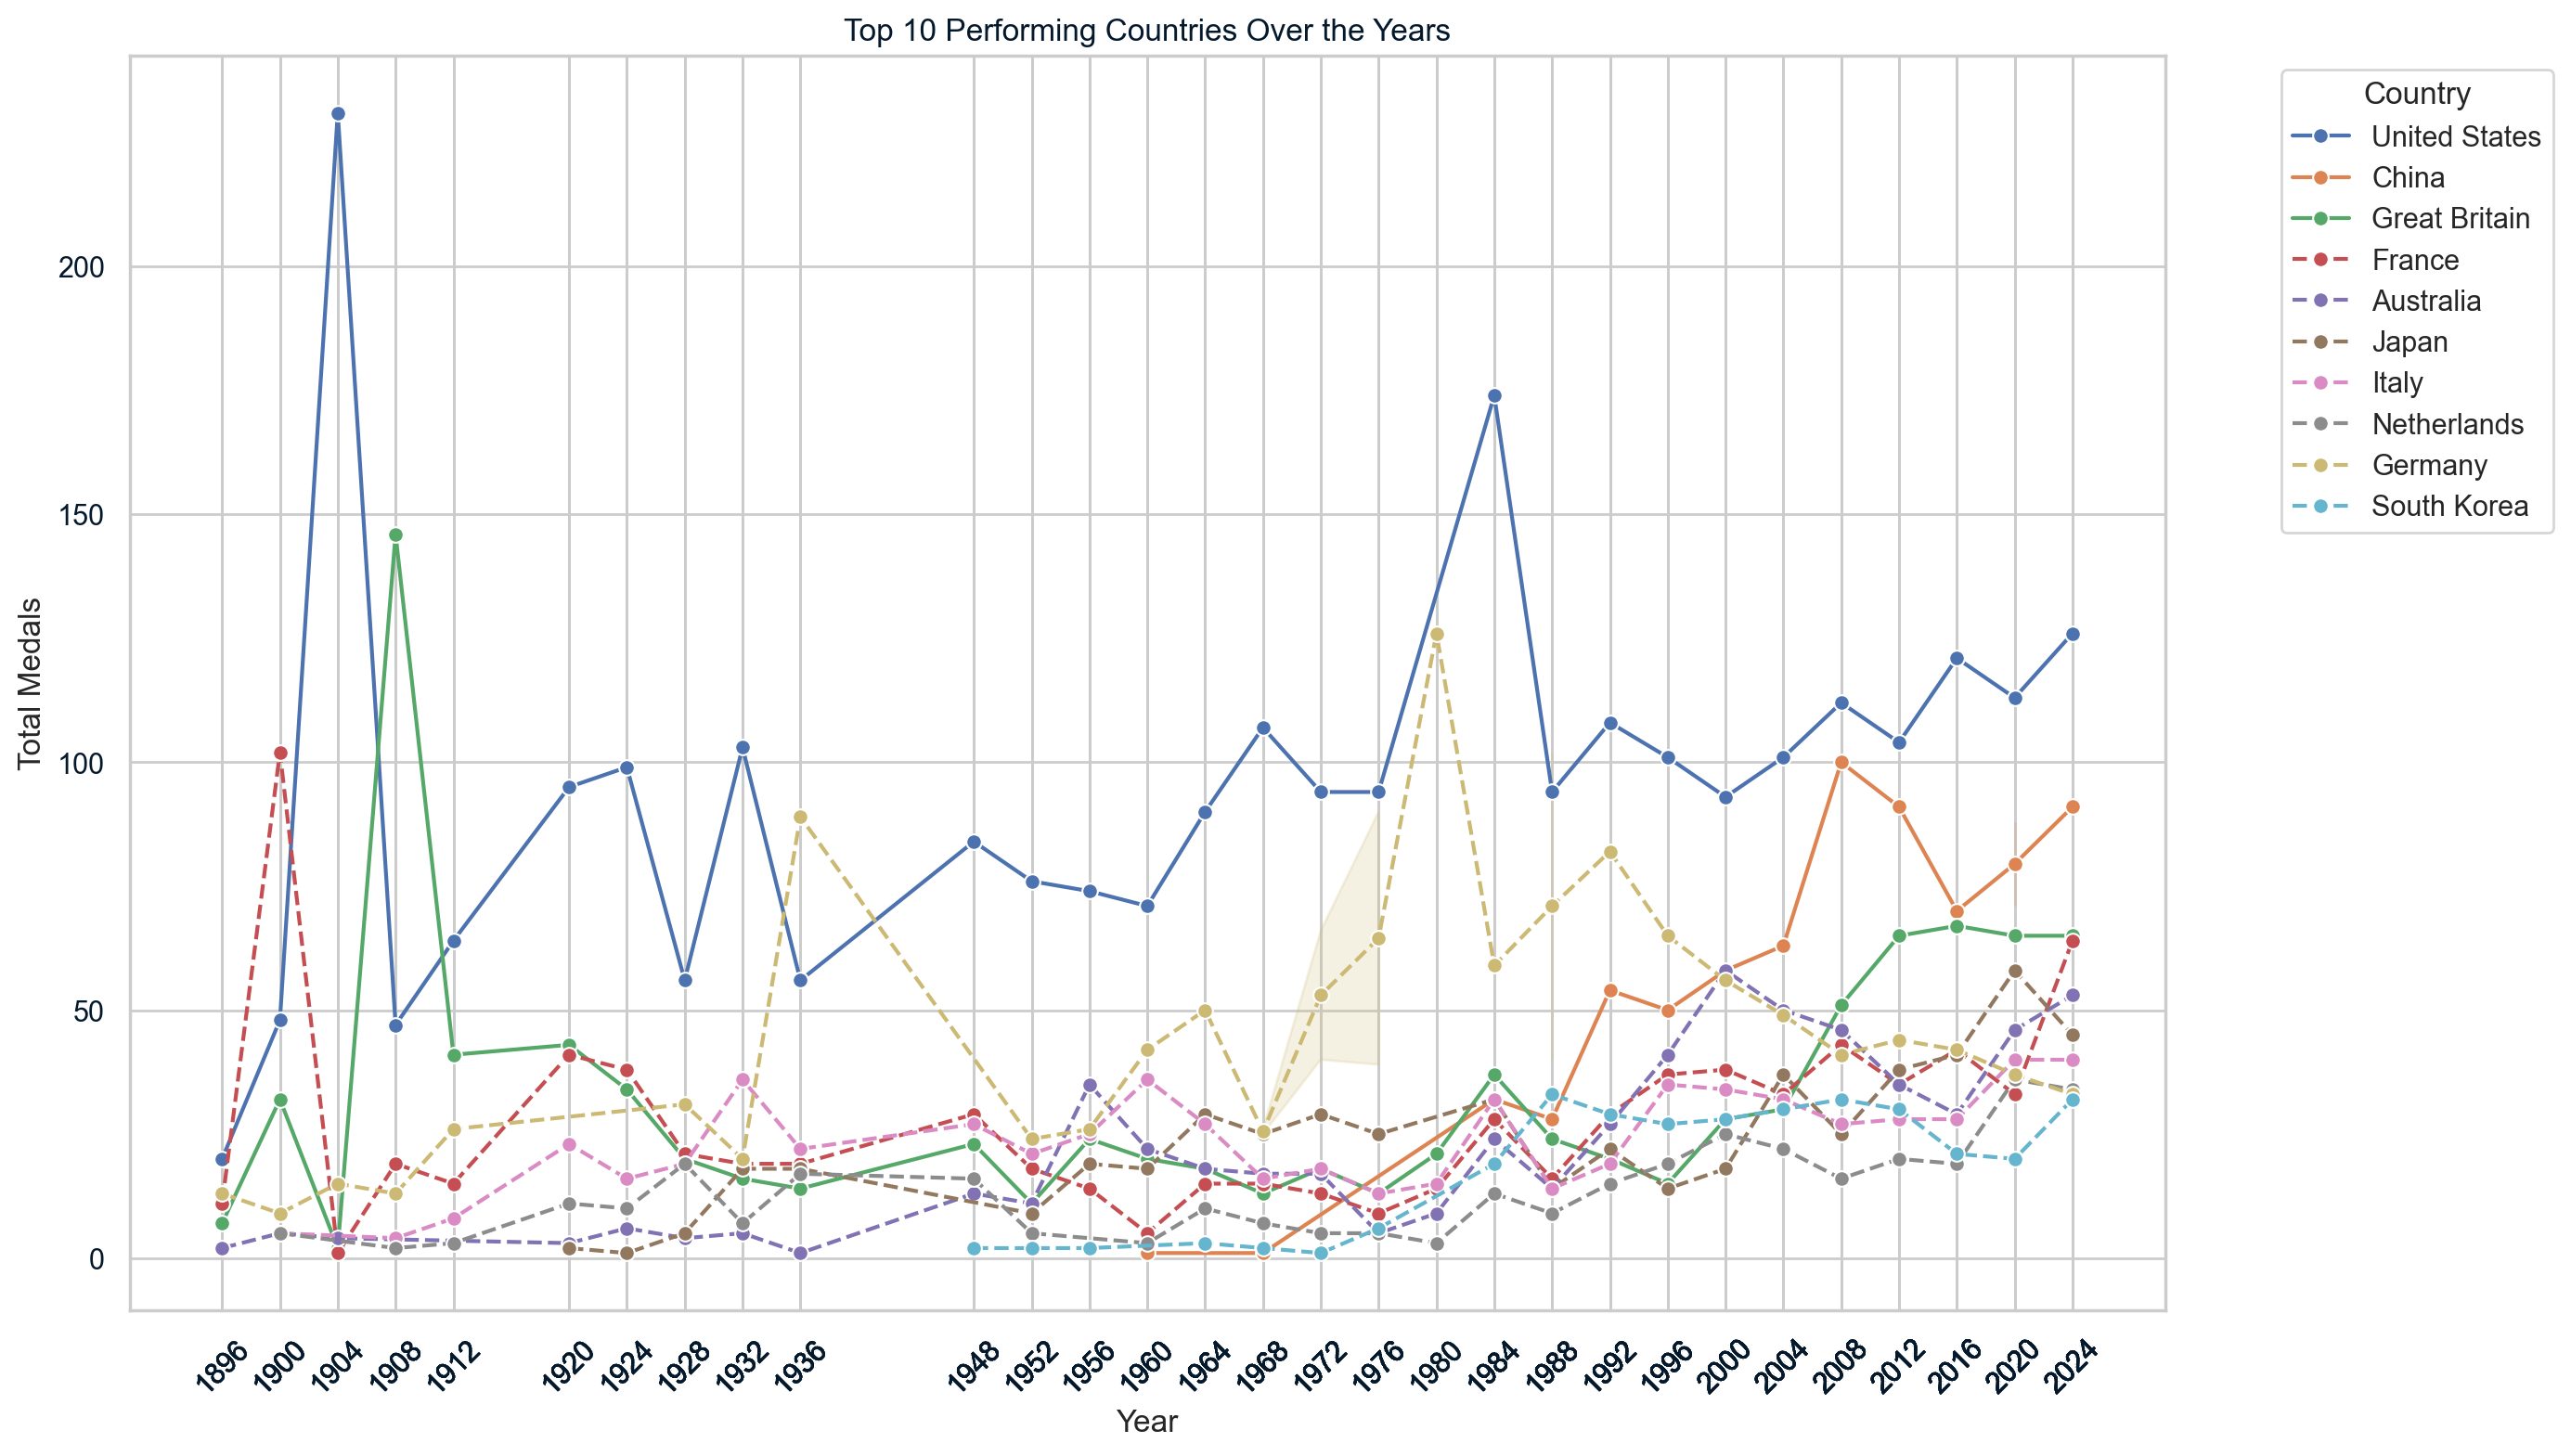

In [41]:
# Get the top 10 countries by total medals in the most recent dataset (2024)
top_10_countries = olympics_2024.nlargest(10, 'Total')['Country']

# Filter the combined dataset to include only the top 10 countries
top_10_data = olympics_combined[olympics_combined['Country'].isin(top_10_countries)]

# Determine the top 3 countries
top_3_countries = top_10_countries.head(3)

plt.figure(figsize=(14, 8))

# Plot top 3 countries with solid lines
for country in top_3_countries:
    country_data = top_10_data[top_10_data['Country'] == country]
    sns.lineplot(data=country_data, x='Year', y='Total', label=country, marker='o', linestyle='-')

# Plot the remaining countries with dashed lines
for country in top_10_countries[3:]:
    country_data = top_10_data[top_10_data['Country'] == country]
    sns.lineplot(data=country_data, x='Year', y='Total', label=country, marker='o', linestyle='--')

# Add titles and labels
plt.title('Top 10 Performing Countries Over the Years')
plt.xlabel('Year')
plt.xticks(top_10_data['Year'], rotation=45)
plt.ylabel('Total Medals')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

### 2. Deep Dive, Country's Medal History 

#### i. United States

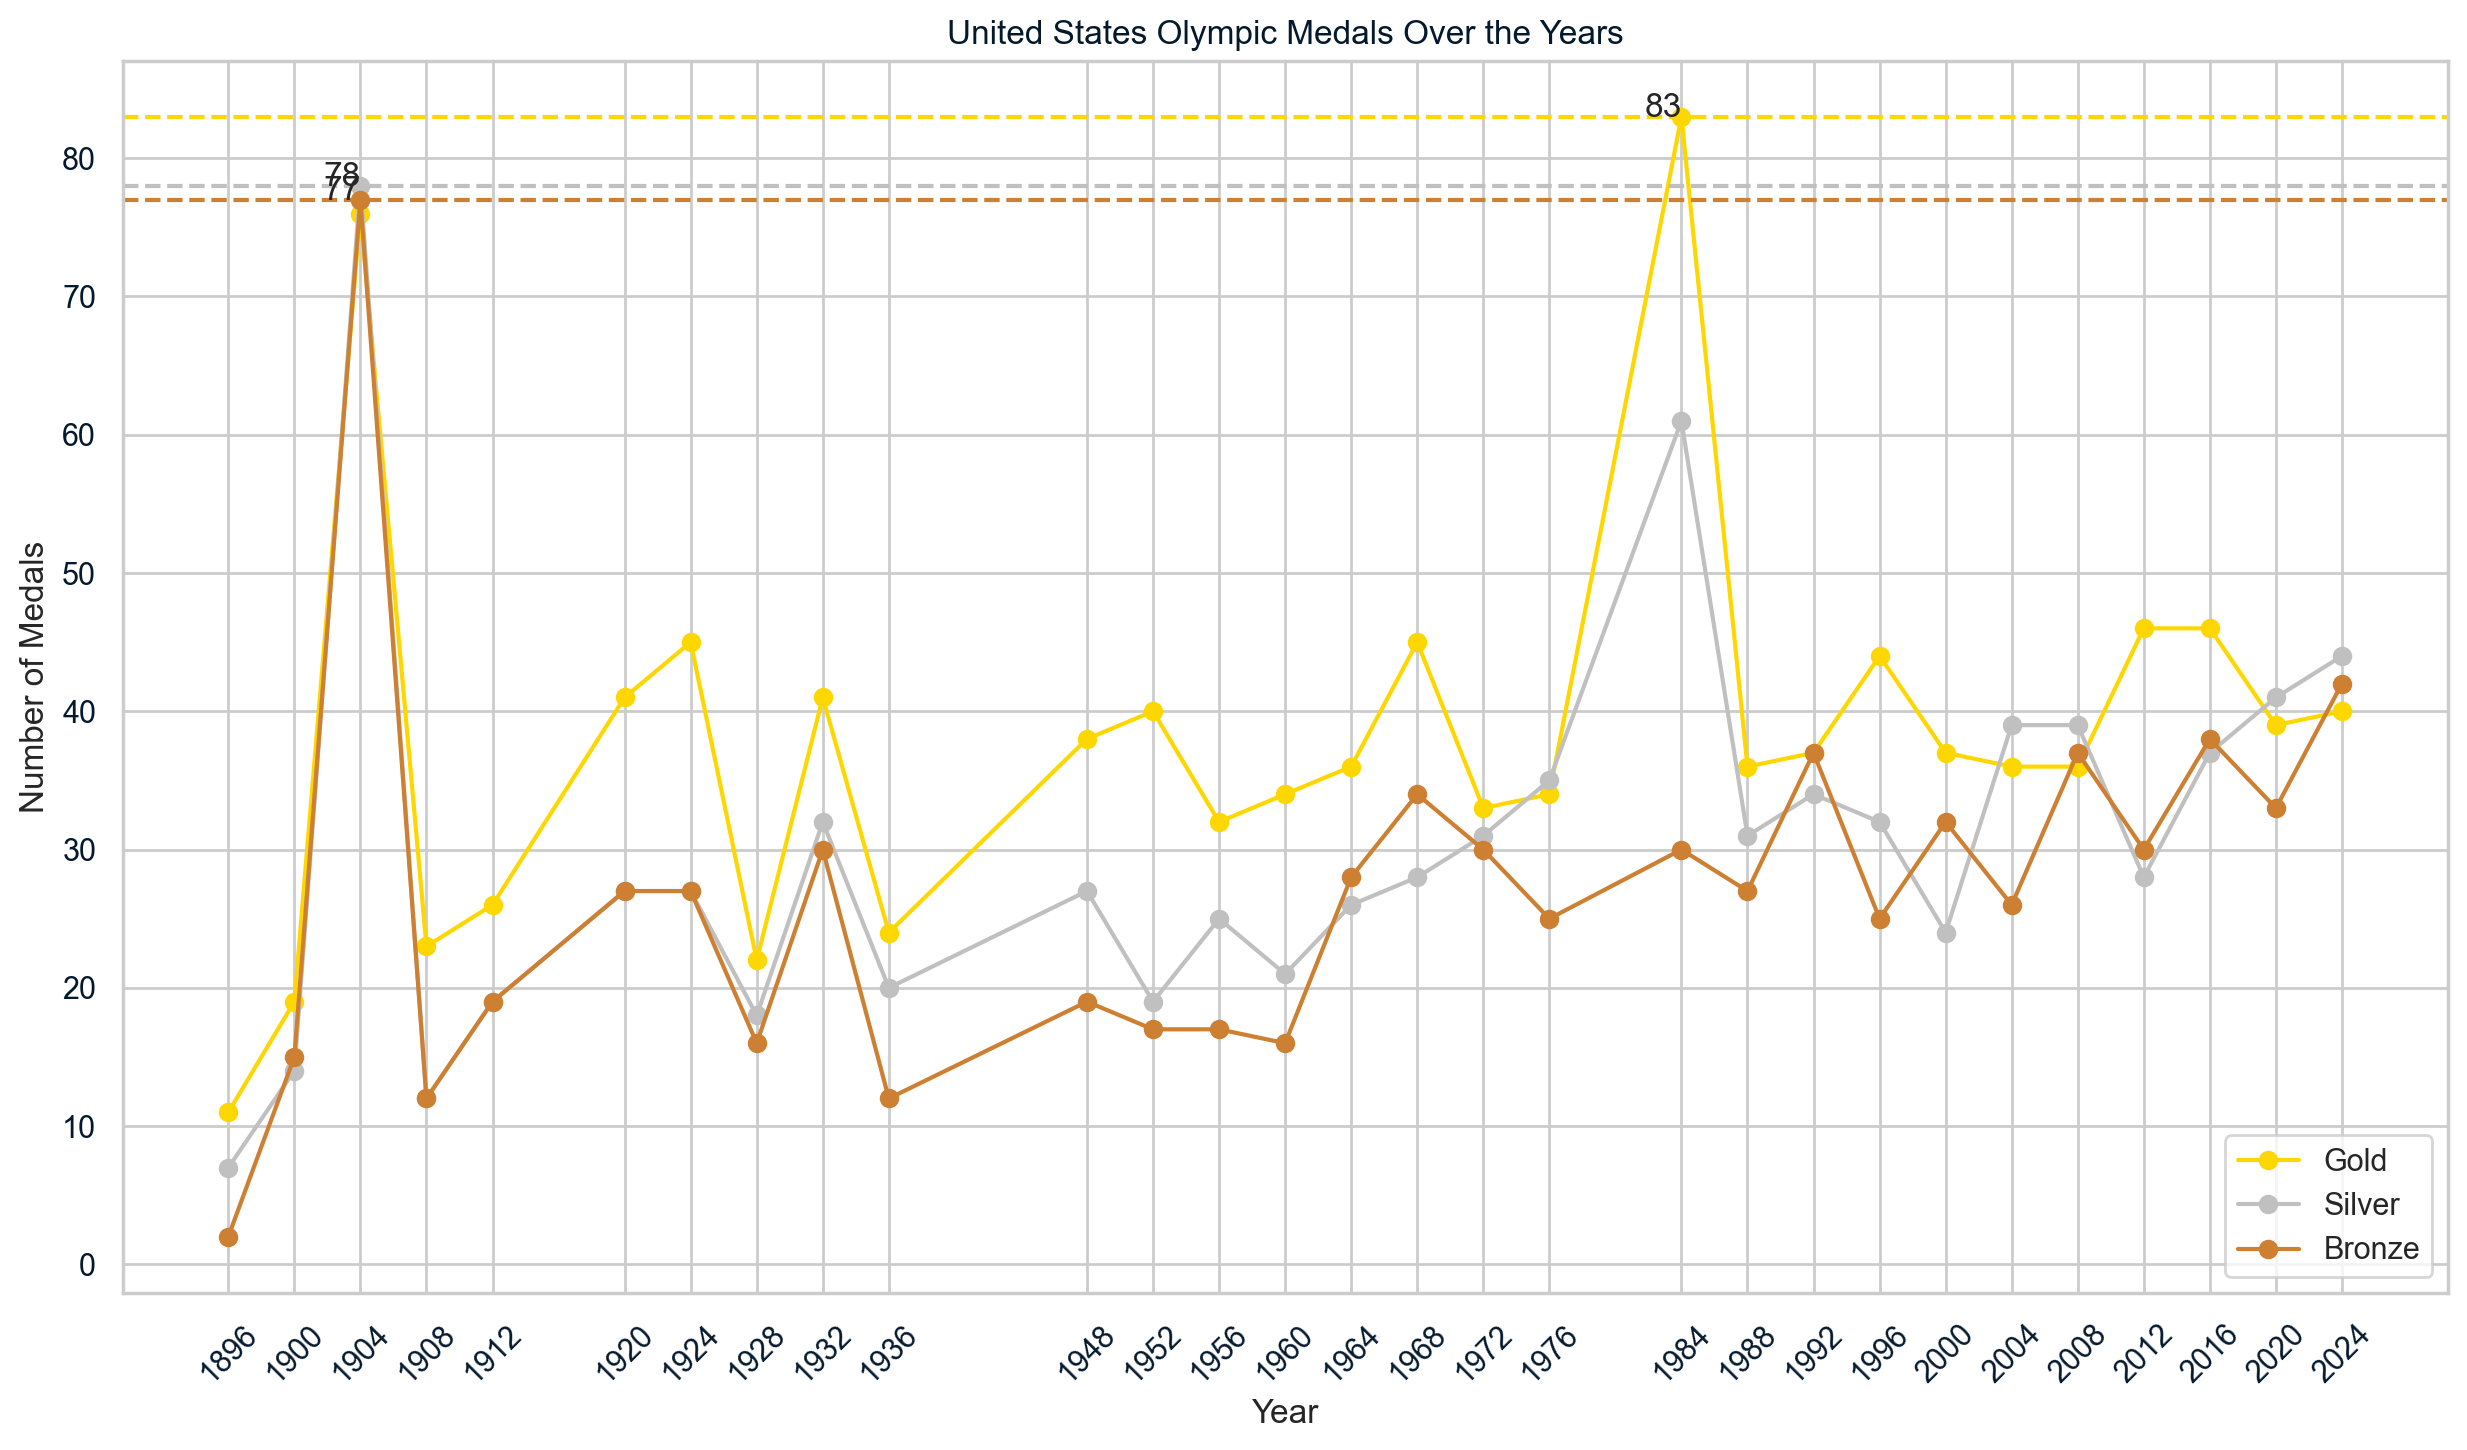

In [42]:
plot_specific_country_medal_performance(olympics_combined, 'United States')

#### ii. China

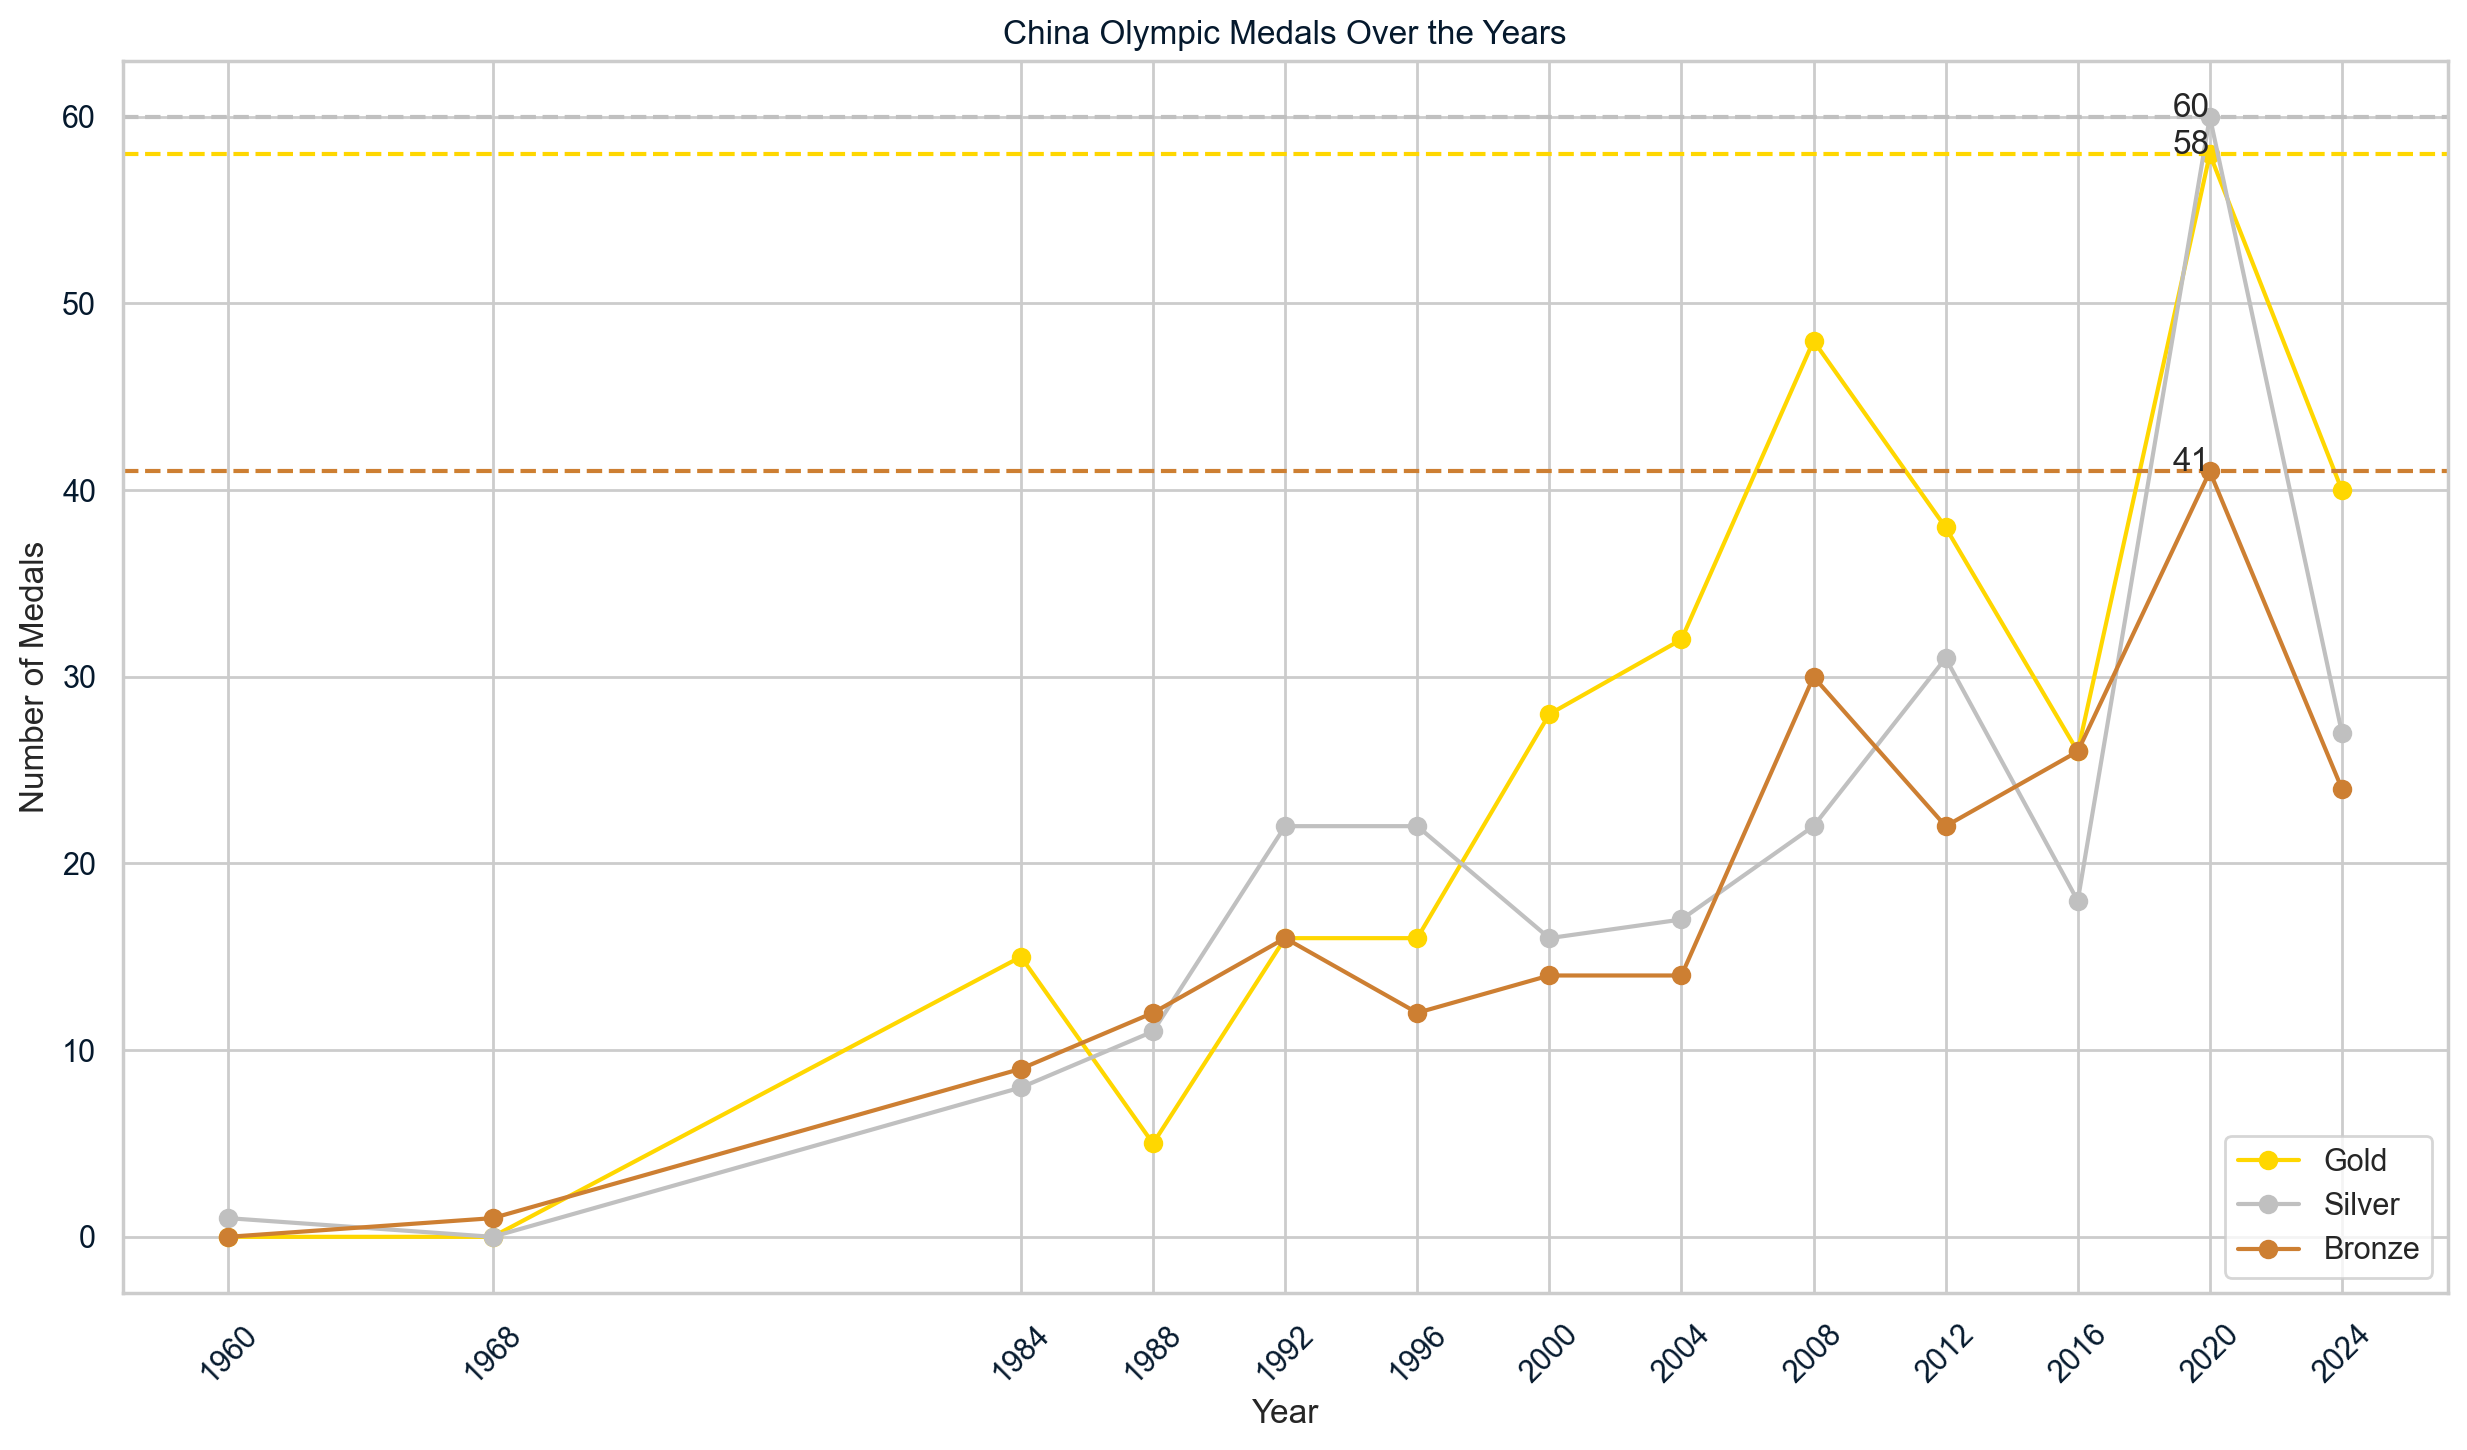

In [43]:
plot_specific_country_medal_performance(olympics_combined, 'China')

#### iii. Great Britain

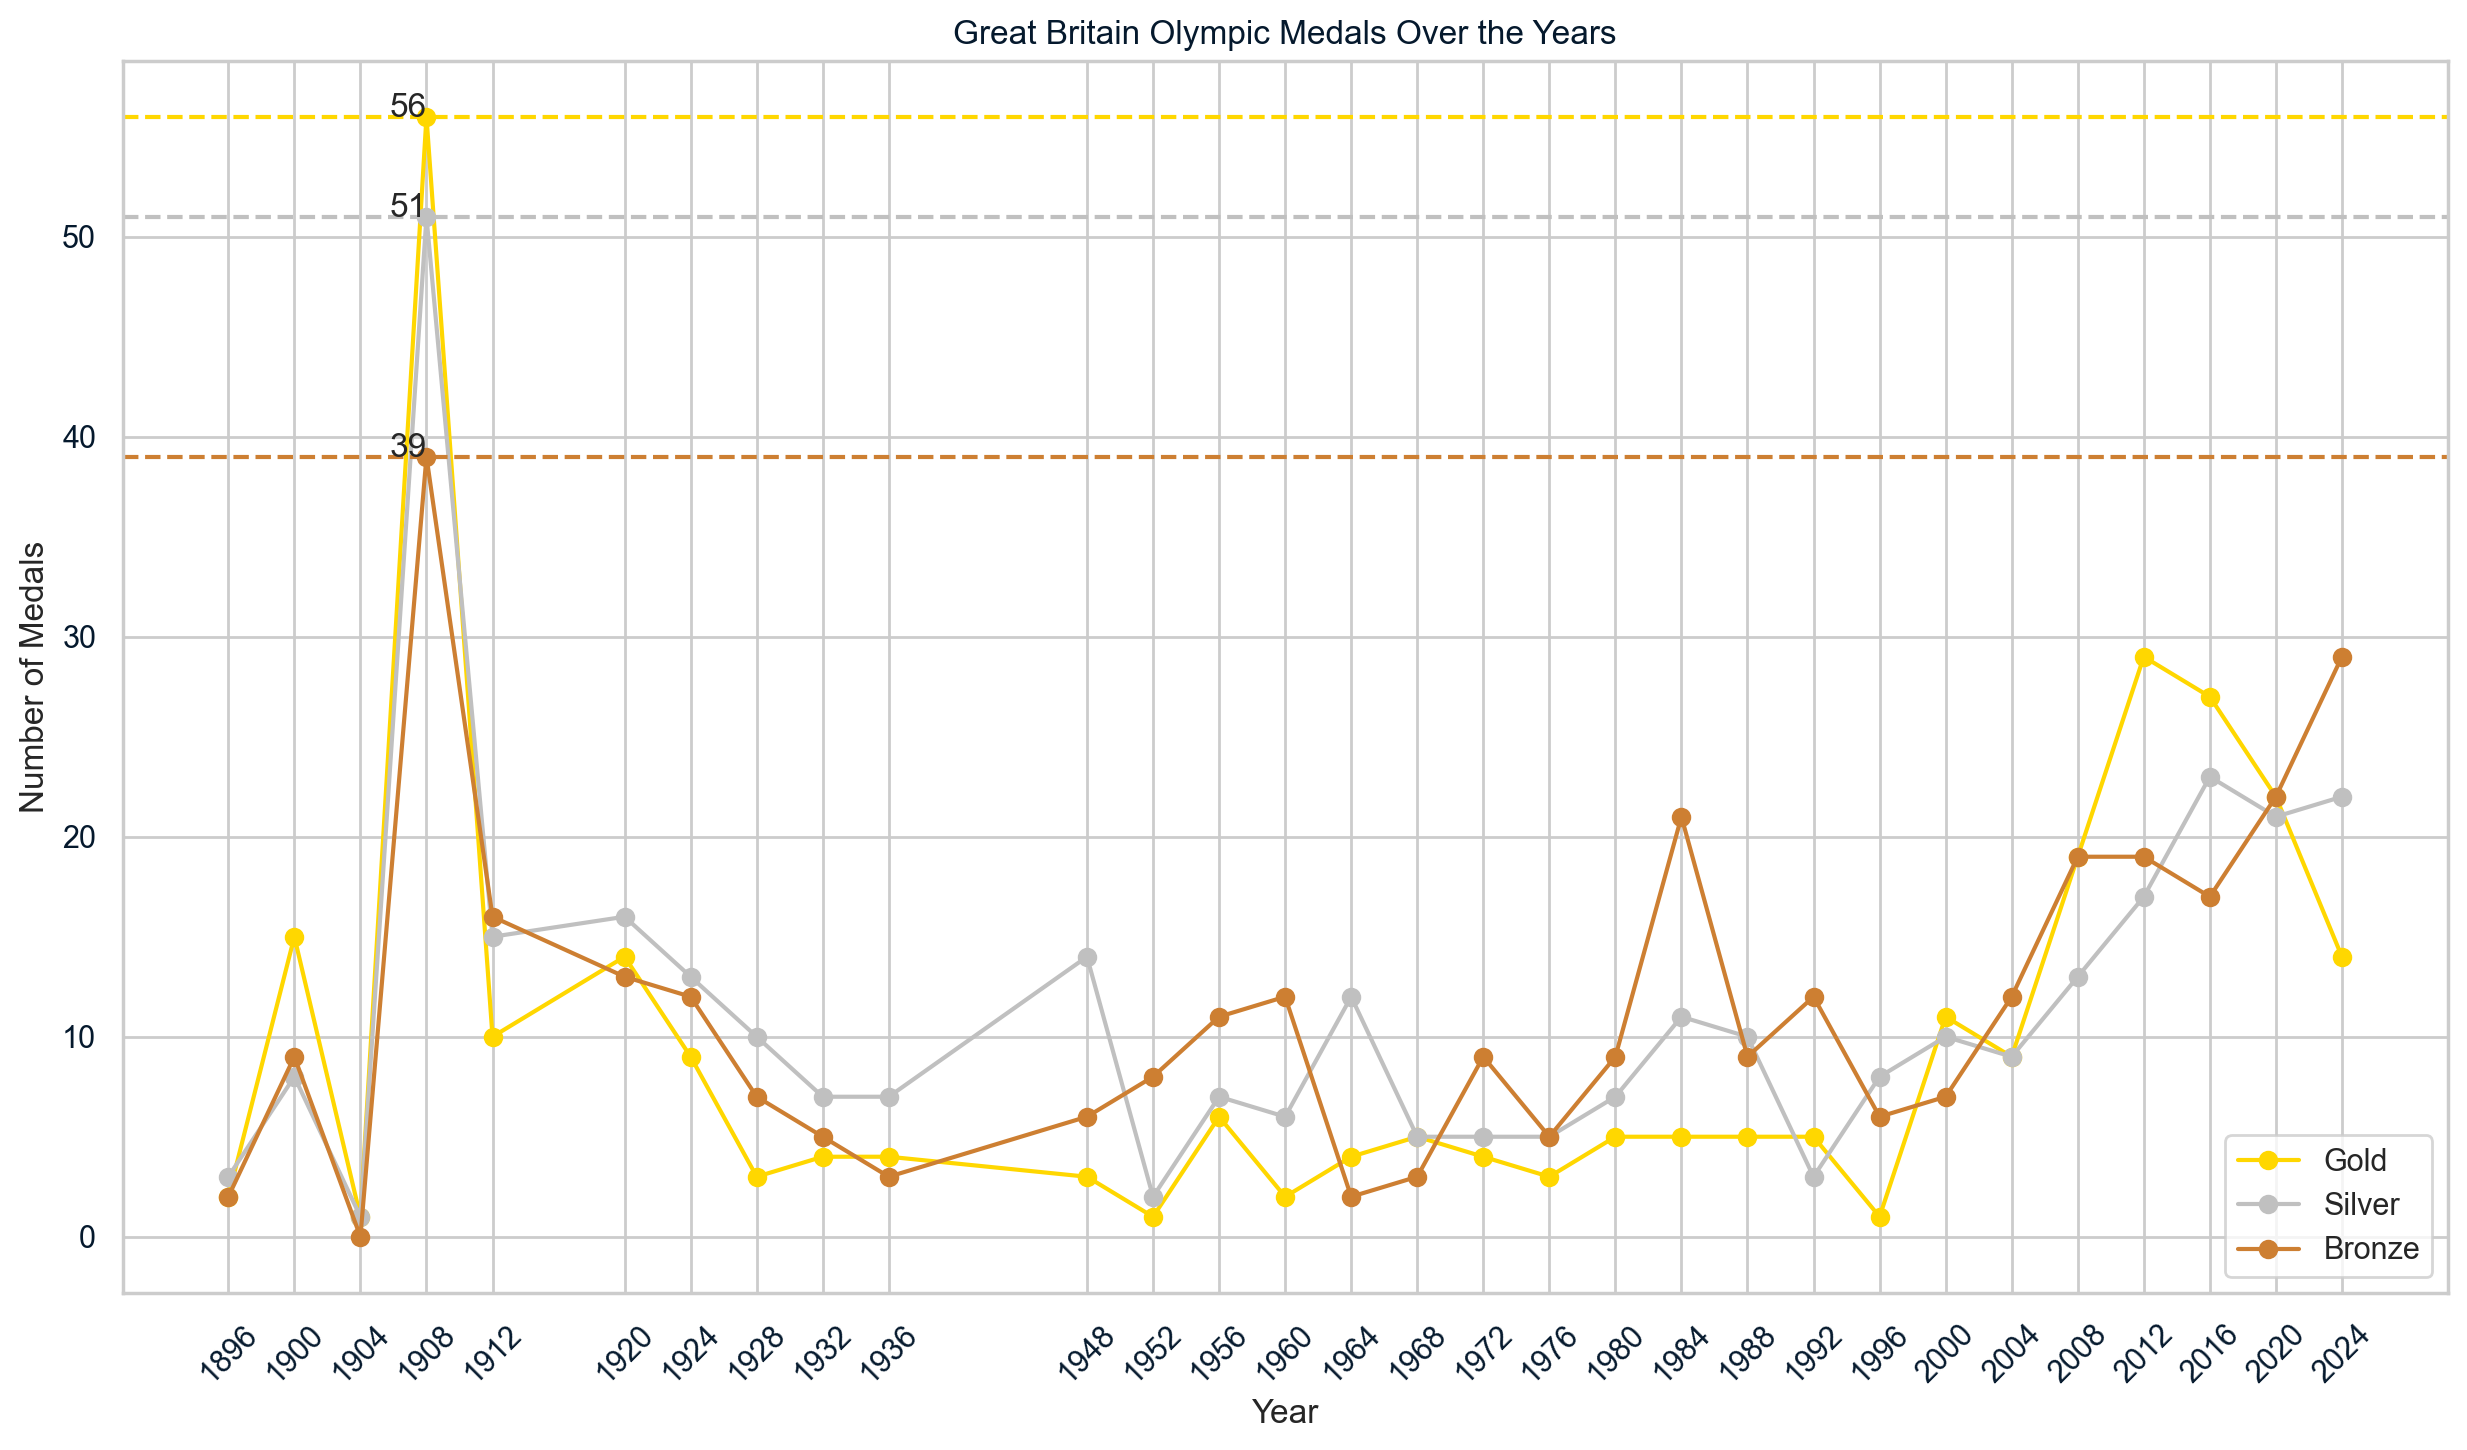

In [44]:
plot_specific_country_medal_performance(olympics_combined, 'Great Britain')